In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, accuracy_score, log_loss

## Dataset Description
1. member_id: unique ID assigned to each member
2. loan_amnt: loan amount applied by the member
3. funded_amnt: loan amount sanctioned by the bank
4. funded_amnt_inv: loan amount sanctioned by the investors
5. term: term of loan (in months)
    - 36 months or 60 months
6. batch_enrolled: batch numbers allotted to members
7. int_rate:	interest rate (%) on loan
8. grade:	grade assigned by the bank
9. sub_grade:	grade assigned by the bank
10. emp_title:	job / Employer title of member
11. emp_length:	employment length, where 0 means less than one year and 10 means ten or more years
12. home_ownership:	status of home ownership
13. annual_inc:	annual income reported by the member
14. verification_status:	status of income verified by the bank
15. pymnt_plan:	indicates if any payment plan has started against loan
16. desc:	loan description provided by member
17. purpose:	purpose of loan
18. title:	loan title provided by member
19. zip_code:	first three digits of area zipcode of member
20. addr_state:	living state of member
21. dti:	ratio of member's total monthly debt repayment excluding mortgage 8. 22. divided by self reported monthly income
23. delinq_2yrs:	number of 30+ days delinquency in past 2 years
24. inq_last_6mths:	number of inquiries in last 6 months
25. mths_since_last_delinq:	number of months since last delinq
26. mths_since_last_record:	number of months since last public record
27. open_acc:	number of open credit line in member's credit line
28. pub_rec:	number of derogatory public records
29. revol_bal:	total credit revolving balance
30. revol_util:	amount of credit a member is using relative to revol_bal
31. total_acc:	total number of credit lines available in members credit line
32. initial_list_status:	unique listing status of the loan - W(Waiting), F(Forwarded)
33. total_rec_int:	interest received till date
34. total_rec_late_fee:	Late fee received till date
35. recoveries:	post charge off gross recovery
36. collection_recovery_fee:	post charge off collection fee
37. collections_12_mths_ex_med:	number of collections in last 12 months excluding medical collections
38. mths_since_last_major_derog:	months since most recent 90 day or worse rating
39. application_type:	indicates when the member is an individual or joint
40. verification_status_joint:	indicates if the joint members income was verified by the bank
41. last_week_pay:	indicates how long (in weeks) a member has paid EMI after batch enrolled
42. acc_now_delinq:	number of accounts on which the member is delinquent
43. tot_coll_amt:	total collection amount ever owed
44. tot_cur_bal	total: current balance of all accounts
45. total_rev_hi_lim:	total revolving credit limit
46. loan_status:	status of loan amount
    - 1 = Defaulter, 0 = Non Defaulters


In [2]:
dataset = "train_indessa.csv"
raw_data = pd.read_csv(dataset)
raw_data['emp_length']

0           9 years
1          < 1 year
2           2 years
3         10+ years
4         10+ years
            ...    
532423    10+ years
532424    10+ years
532425      8 years
532426       1 year
532427     < 1 year
Name: emp_length, Length: 532428, dtype: object

#### Data descriptions

In [3]:
# raw_data.head()
# raw_data.info()
raw_raw_data = raw_data.copy()
# raw_data.describe(include = 'all')
#raw_data.columns

In [4]:
# raw_data.isnull().sum()

#20 columns with missing values
#total rows: 532428

#emp_title - 30833
#emp_length - 26891
#annual_inc - 3
#desc - 456829
#title - 90
#delinq_2yrs - 16
#inq_last_6mths - 16
#mths_since_last_delinq - 272554
#mths_since_last_record - 450305
#open_acc - 16
#pub_rec - 16
#revol_util - 287
#total_acc - 16
#collections_12_mths_ex_med - 95
#mths_since_last_major_derog - 399448
#verification_status_joint - 532123
#acc_now_delinq - 16
#tot_coll_amt - 42004
#tot_cur_bal - 42004
#total_rev_hi_lim - 42004

In [5]:
#unique values for categorial variables
# raw_data[['term', 'grade', 'sub_grade', 'emp_title', 'emp_length','home_ownership', 'verification_status',
#          'pymnt_plan', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status',
#          'application_type', 'verification_status_joint', 'last_week_pay']].nunique()

In [6]:
# raw_data.hist(figsize=(10,10))
# plt.tight_layout()

# METHOD1: Manual WoE & IV

## Data Pre-Processing

In [7]:
#first drop - remove columns that are not useful for prediction
raw_data = raw_data.drop(columns=['member_id', 'batch_enrolled', 'verification_status_joint'])

#member_id - unique value given by the bank to each member
#batch_enrolled - batch number given by the bank to each member
#verification_status_joint - only for joint accounts, however insignificant number of joint accounts

In [8]:
raw_data['application_type'].value_counts()

INDIVIDUAL    532123
JOINT            305
Name: application_type, dtype: int64

In [9]:
#second drop - remove rows with 'JOINT' under application type (too little values: 305)
raw_data = raw_data[raw_data.application_type != 'JOINT']

In [10]:
#third drop - drop rows with missing values for certain variables (less than 300)
raw_data = raw_data.dropna(subset=['annual_inc', 'title', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
                                   'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq'])

In [11]:
#fourth drop - retain rows with at least 20 non-null values
raw_data.dropna(thresh= 20, inplace = True)

#raw_data
#no rows were dropped

In [12]:
#fifth drop - drop categorial variables with too many unique values (>=100)
raw_data = raw_data.drop(columns=['emp_title','desc','title','zip_code'])

#### Encode Data

In [13]:
#last_week_pay
raw_data['last_week_pay'] = raw_data['last_week_pay'].str.extract('(\d+)').astype(float)

In [14]:
#initial_list_status

variable = 'initial_list_status'
# sort by asc initial_list_status, f = 0, w = 1
def encode_initial_list_status(x):
    if x == 'f':
        return 0
    elif x == 'w':
        return 1

raw_data[variable]  = raw_data[variable].apply(encode_initial_list_status)

In [15]:
#term

variable = 'term'
# sort by term, 36 months = 36, 60 months = 60
def encode_term(x):
    if x == '36 months':
        return 36
    elif x == '60 months':
        return 60

raw_data[variable]  = raw_data[variable].apply(encode_term)

In [16]:
#verification_status

variable = 'verification_status'

# sort by asc verification_status, Not Verified = 0,  Verified and Source Verified = 1
def encode_verification_status(x):
    if x == 'Not Verified':
        return 0
    elif x == 'Verified':
        return 1
    elif x == 'Source Verified':
        return 1
raw_data[variable]  = raw_data[variable].apply(encode_verification_status)

In [17]:
#purpose

variable = 'purpose'

raw_data = raw_data.sort_values(by=[variable])
labels1, levels1 = pd.factorize(raw_data[variable])
raw_data[variable] = labels1

# sort by alphabetical order, car = 0, credit_card = 1, debt_consolidation = 2, educational = 3, 
# home_improvement = 4, house = 5, major_purchase = 6, medical = 7, moving = 8, other = 9, renewable_energy = 10,
# small_business = 11, vacation = 12, wedding = 13

In [18]:
#addr_state

variable = 'addr_state'

raw_data = raw_data.sort_values(by=[variable])
labels2, levels2 = pd.factorize(raw_data[variable])
raw_data[variable] = labels2

In [19]:
#sub_grade

variable = 'sub_grade'

raw_data = raw_data.sort_values(by=[variable])
labels3, levels3 = pd.factorize(raw_data[variable])
raw_data[variable] = labels3

# sort by asc sub_grade so 
# A1 = 0 , A2 = 1, A3 = 2, A4, = 3, A5 = 4, 
# B1 = 5 , B2 = 6, B3 = 7, B4, = 8, B5 = 9,
# C1 = 10 , C2 = 11, C3 = 12, C4, = 13, C5 = 14,
# D1 = 15 , D2 = 16, D3 = 17, D4, = 18, D5 = 19,
# E1 = 20 , E2 = 21, E3 = 22, E4, = 23, E5 = 24,
# F1 = 25 , F2 = 26, F3 = 27, F4, = 28, F5 = 29,
# G1 = 30 , G2 = 31, G3 = 32, G4, = 33, G5 = 34,

In [20]:
#grade

variable = 'grade'

raw_data = raw_data.sort_values(by=[variable])
labels4, levels4 = pd.factorize(raw_data[variable])
raw_data[variable] = labels4

# sort by asc grade so 
# A = 0 , B = 1, C = 2, D, = 3, E = 4, F = 5 , G = 6

In [21]:
# check if data is properly encoded
raw_data[['last_week_pay', 'initial_list_status', 'term', 'verification_status','purpose', 'addr_state',
          'sub_grade', 'grade']].head()

,last_week_pay,initial_list_status,term,verification_status,purpose,addr_state,sub_grade,grade
166060,65.0,1,36,1,1,10,0,0
310080,157.0,0,36,1,2,4,3,0
60173,4.0,1,36,1,9,22,3,0
166246,100.0,0,36,1,2,4,3,0
238022,113.0,0,36,0,2,6,3,0


<AxesSubplot:>

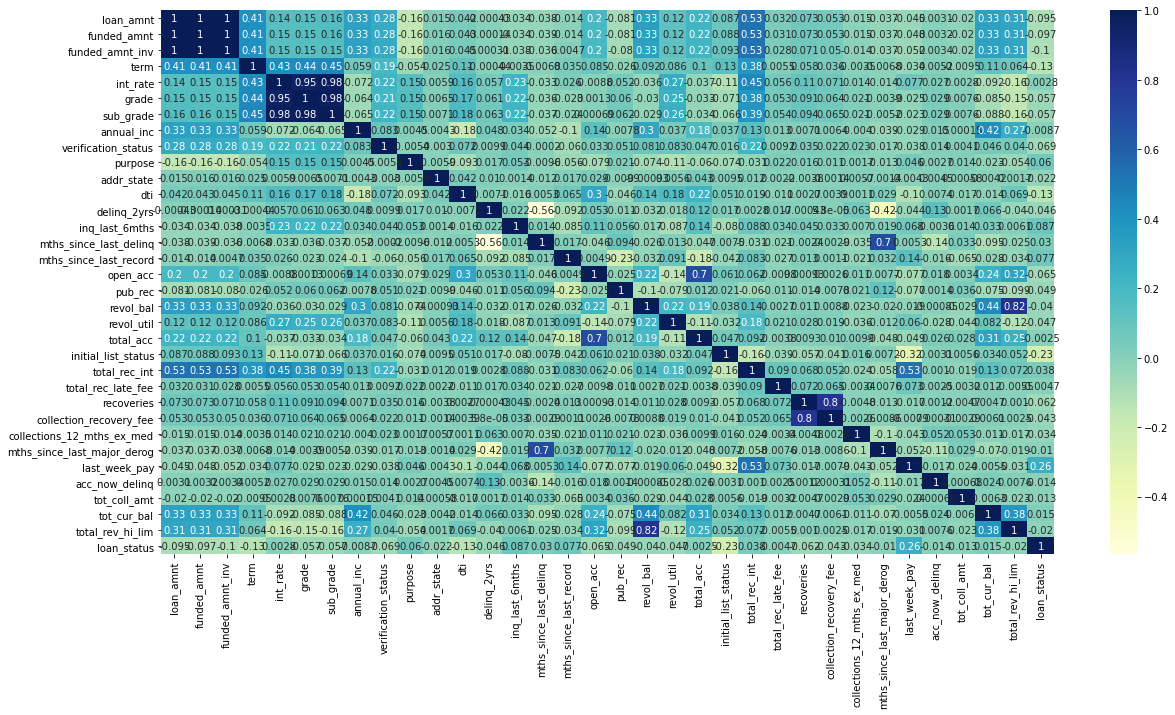

In [22]:
# Generate correlation maxtrix
cor = raw_data.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,cmap="YlGnBu", ax=ax)

In [23]:
#sixth drop - remove highly correlated columns to counter multicollinearity  (>=0.8)
raw_data = raw_data.drop(columns=['loan_amnt','funded_amnt_inv','total_rev_hi_lim','recoveries', 'grade',
                                 'int_rate'])

In [24]:
#####################
# METHOD 1 FUNCTION #
# WOE IV RE-BINNING #
#####################

## IV Calculation Function

In [25]:
# WoE function 

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        #for numeric/float columns use pd.qcut to bin
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            col_name = ivars + '_bin'
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events'] - d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
            
    return newDF, woeDF

##### Run the raw data for IV

In [26]:
# # get the raw IV
iv_df, woe_df = iv_woe(raw_data, "loan_status")
iv_df.sort_values(by='IV', ascending=False).round(4)

,Variable,IV
0,last_week_pay,0.3762
0,initial_list_status,0.3086
0,dti,0.1080
0,term,0.1047
0,mths_since_last_record,0.0976
0,total_rec_int,0.0707
0,funded_amnt,0.0567
0,inq_last_6mths,0.0321
0,sub_grade,0.0258
0,verification_status,0.0252


In [27]:
#seventh drop - dropped variables with insignificant IV (< 0.02)
# less than 0.02 - not useful for prediction
# 0.02 to 0.1 - weak predictive power
# 0.1 to 0.3 - medium predictive power
# 0.3 to 0.5 - strong predictive power
# more than 0.5 - suspicious predictive power


raw_data = raw_data.drop(columns=['application_type', 'collection_recovery_fee', 'total_rec_late_fee', 'pymnt_plan', 
                                  'total_acc', 'annual_inc', 'acc_now_delinq', 'mths_since_last_major_derog',
                                  'home_ownership', 'tot_cur_bal', 'mths_since_last_delinq', 'delinq_2yrs', 
                                  'tot_coll_amt', 'collections_12_mths_ex_med', 'addr_state', 'emp_length',
                                  'pub_rec', 'purpose','revol_util'])

#everything that is less than 0.02 is dropped

In [28]:
raw_data

,funded_amnt,term,sub_grade,verification_status,dti,inq_last_6mths,mths_since_last_record,open_acc,revol_bal,initial_list_status,total_rec_int,last_week_pay,loan_status
166060,22850,36,0,1,28.72,0.0,NaN,14.0,87180.0,1,1390.05,65.0,0
310080,22000,36,3,1,23.67,0.0,NaN,9.0,17842.0,0,2625.73,157.0,1
60173,6000,36,3,1,10.09,0.0,NaN,15.0,34791.0,1,31.46,4.0,1
166246,3050,36,3,1,10.12,0.0,NaN,14.0,16934.0,0,330.32,100.0,0
238022,7000,36,3,0,14.37,0.0,115.0,5.0,6959.0,0,808.69,113.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235537,16150,60,30,1,13.60,5.0,NaN,10.0,11204.0,0,7132.19,100.0,0
476382,20000,60,30,1,19.93,1.0,NaN,9.0,15193.0,1,11244.75,144.0,0
94757,11750,60,30,1,16.67,0.0,NaN,6.0,3830.0,0,244.65,4.0,0
450482,5950,36,30,1,24.08,2.0,NaN,9.0,7273.0,0,1159.49,43.0,0


##### Check the bins for all columns  

Text(0.5, 1.0, 'WOE plot for last_week_pay bin adjusted')

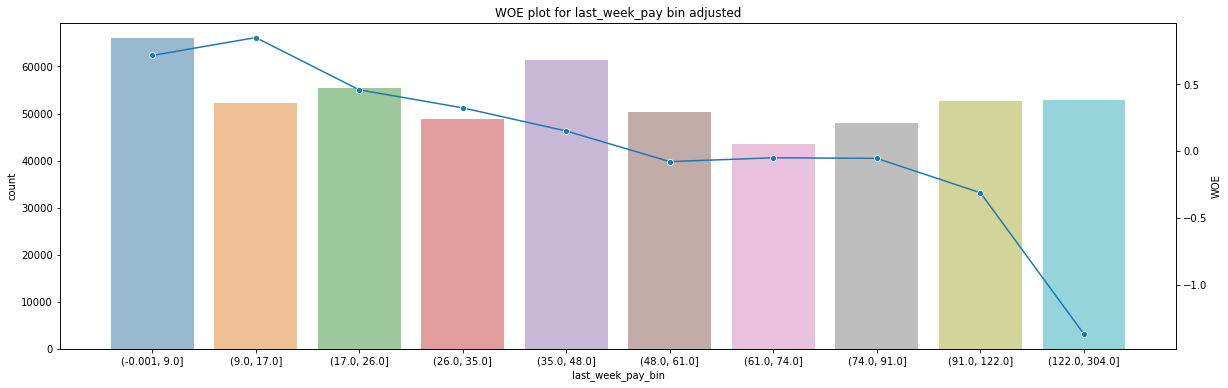

In [29]:
# 1. last_week_pay

raw_data['last_week_pay'].fillna(0,inplace=True)
#fill with 0 as blanks means that the customer has not paid its monthly installment yet
#or that it is not necessary to pay the EMI

########
# BEFORE
########

# # # step 1 show the col in 10 bins
raw_data['last_week_pay_bin'] = pd.qcut(raw_data['last_week_pay'],q= 10)
raw_data['last_week_pay_bin'] = raw_data['last_week_pay_bin'].astype('object')

# # step 2
last_week_pay = pd.DataFrame()
last_week_pay['last_week_pay_bin'] = raw_data.groupby(by='last_week_pay_bin', as_index=False).count()['last_week_pay_bin']
last_week_pay['count'] = raw_data.groupby(by='last_week_pay_bin', as_index=False).count()['loan_status']
last_week_pay['Events'] = raw_data.groupby(by='last_week_pay_bin', as_index=False).sum()['loan_status']
last_week_pay['Non_Events'] = last_week_pay['count'] - last_week_pay['Events']
last_week_pay['total_distri'] = last_week_pay['count']/sum(last_week_pay['count'])
last_week_pay['%_of_Events'] = last_week_pay['Events']/sum(last_week_pay['Events'])
last_week_pay['%_of_Non_Events'] = last_week_pay['Non_Events']/sum(last_week_pay['Non_Events'])
last_week_pay['WOE'] = np.log(last_week_pay['%_of_Non_Events'] / last_week_pay['%_of_Events'])
last_week_pay['IV'] = (last_week_pay['%_of_Non_Events']-last_week_pay['%_of_Events'])*last_week_pay['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = last_week_pay['last_week_pay_bin'] , y = last_week_pay['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = last_week_pay['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for last_week_pay bin adjusted")

Text(0.5, 1.0, 'WOE plot for initial_list_status bin adjusted')

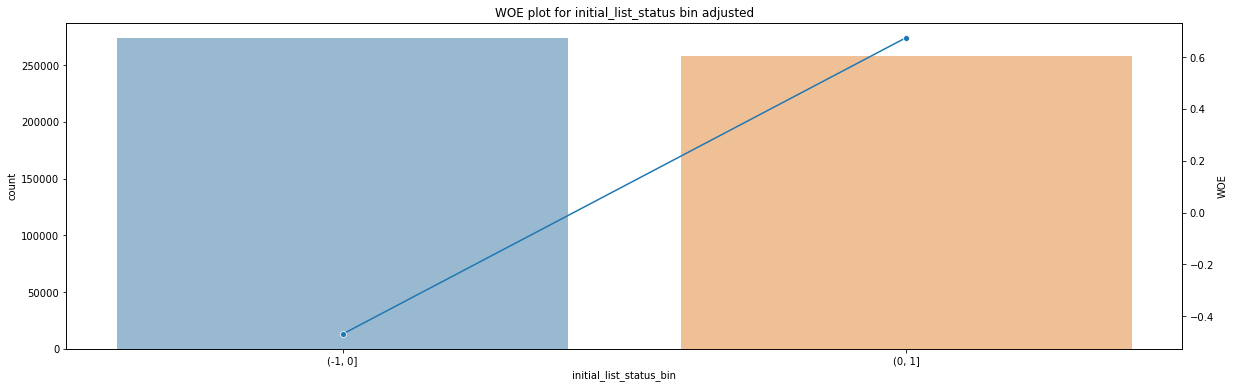

In [30]:
# 2. initial_list_status

variable = 'initial_list_status'

########
# BEFORE
########

# # # step 1 show the col in 10 bins
bin_edges = [-1,0,1] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
initial_list_status = pd.DataFrame()
initial_list_status[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
initial_list_status['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
initial_list_status['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
initial_list_status['Non_Events'] = initial_list_status['count'] - initial_list_status['Events']
initial_list_status['total_distri'] = initial_list_status['count']/sum(initial_list_status['count'])
initial_list_status['%_of_Events'] = initial_list_status['Events']/sum(initial_list_status['Events'])
initial_list_status['%_of_Non_Events'] = initial_list_status['Non_Events']/sum(initial_list_status['Non_Events'])
initial_list_status['WOE'] = np.log(initial_list_status['%_of_Non_Events'] / initial_list_status['%_of_Events'])
initial_list_status['IV'] = (initial_list_status['%_of_Non_Events']-initial_list_status['%_of_Events'])*initial_list_status['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = initial_list_status[variable+'_bin'] , y = initial_list_status['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = initial_list_status['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for dti bin adjusted')

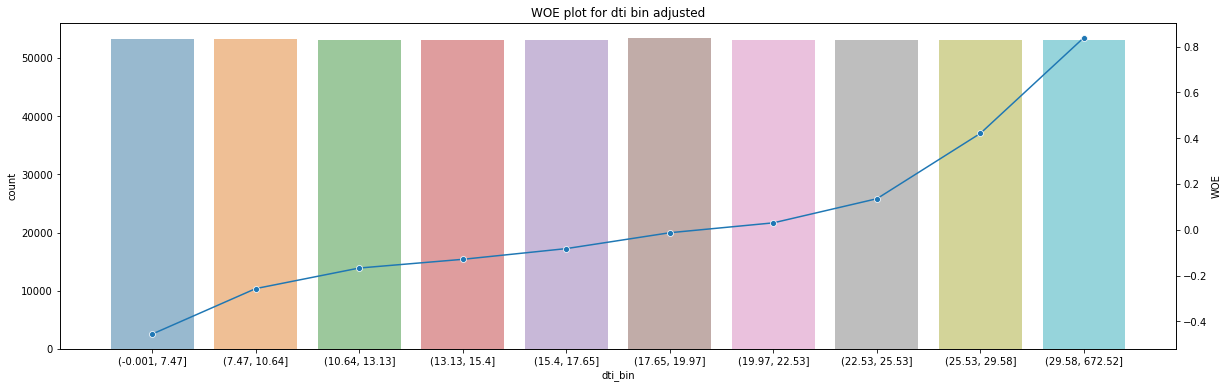

In [31]:
# 3. dti

########
# BEFORE
########

# step 1 show the col in 10 bins
raw_data['dti_bin'] = pd.qcut(raw_raw_data['dti'],q= 10)

# # step 2
dti = pd.DataFrame()
dti['dti_bin'] = raw_data.groupby(by='dti_bin', as_index=False).count()['dti_bin']
dti['count'] = raw_data.groupby(by='dti_bin', as_index=False).count()['loan_status']
dti['Events'] = raw_data.groupby(by='dti_bin', as_index=False).sum()['loan_status']
dti['Non_Events'] = dti['count'] - dti['Events']
dti['total_distri'] = dti['count']/sum(dti['count'])
dti['%_of_Events'] = dti['Events']/sum(dti['Events'])
dti['%_of_Non_Events'] = dti['Non_Events']/sum(last_week_pay['Non_Events'])
dti['WOE'] = np.log(dti['%_of_Non_Events'] / dti['%_of_Events'])
dti['IV'] = (dti['%_of_Non_Events']-dti['%_of_Events'])*dti['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = dti['dti_bin'] , y = dti['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = dti['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for dti bin adjusted")

Text(0.5, 1.0, 'WOE plot for term bin adjusted')

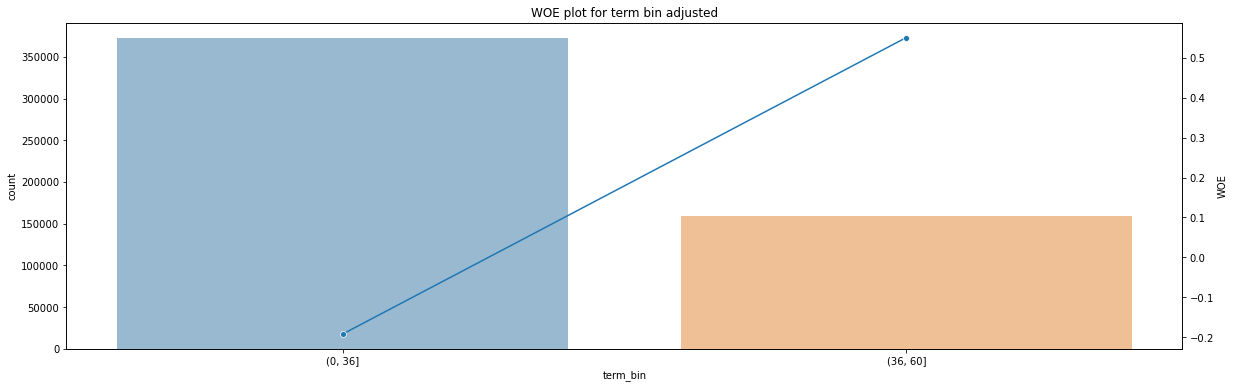

In [32]:
# 4. term

variable = 'term'

########
# BEFORE
########

# # # step 1 show the col in 10 bins
bin_edges = [0, 36,60] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
term = pd.DataFrame()
term[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
term['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
term['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
term['Non_Events'] = term['count'] - term['Events']
term['total_distri'] = term['count']/sum(term['count'])
term['%_of_Events'] = term['Events']/sum(term['Events'])
term['%_of_Non_Events'] = term['Non_Events']/sum(term['Non_Events'])
term['WOE'] = np.log(term['%_of_Non_Events'] / term['%_of_Events'])
term['IV'] = (term['%_of_Non_Events']-term['%_of_Events'])*term['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = term[variable+'_bin'] , y = term['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = term['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for mths_since_last_record bin adjusted')

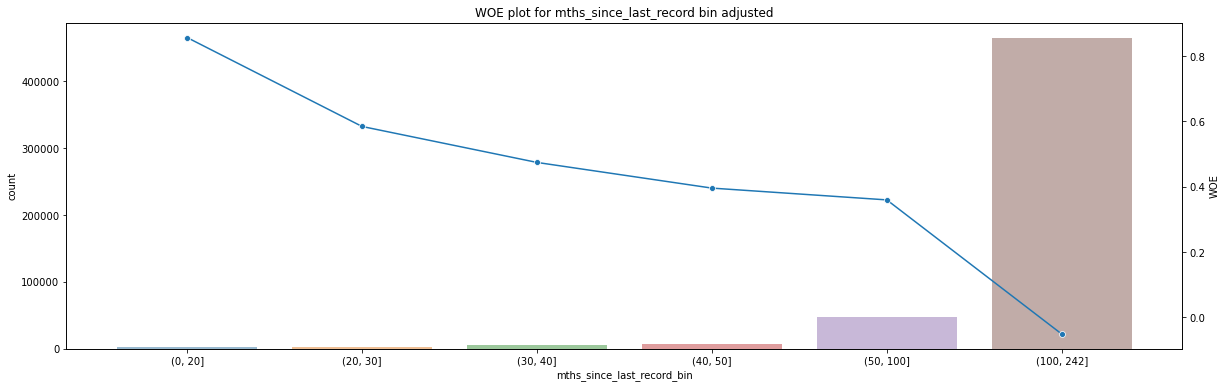

In [33]:
# 5. mths_since_last_record

variable = 'mths_since_last_record'

max_value = raw_data[variable].max()
max_value *= 2
raw_data[variable].fillna(max_value,inplace=True)
#we fill with max value x2 as 0 does not fulfil the assumption that the customer does not have any record
#max value x2 will be better as it tells us that it has been quite sometime since the customer had a record.

#########
# BEFORE#
# #######

# # # # # step 1 show the col in 10 bins
bin_edges = [0,20,30,40,50,100,242] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # # step 2
mths_since_last_record = pd.DataFrame()
mths_since_last_record[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
mths_since_last_record['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
mths_since_last_record['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
mths_since_last_record['Non_Events'] = mths_since_last_record['count'] - mths_since_last_record['Events']
mths_since_last_record['total_distri'] = mths_since_last_record['count']/sum(mths_since_last_record['count'])
mths_since_last_record['%_of_Events'] = mths_since_last_record['Events']/sum(mths_since_last_record['Events'])
mths_since_last_record['%_of_Non_Events'] = mths_since_last_record['Non_Events']/sum(mths_since_last_record['Non_Events'])
mths_since_last_record['WOE'] = np.log(mths_since_last_record['%_of_Non_Events'] / mths_since_last_record['%_of_Events'])
mths_since_last_record['IV'] = (mths_since_last_record['%_of_Non_Events']-mths_since_last_record['%_of_Events'])*mths_since_last_record['WOE']


# # # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = mths_since_last_record[variable+'_bin'] , y = mths_since_last_record['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = mths_since_last_record['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for total_rec_int bin adjusted')

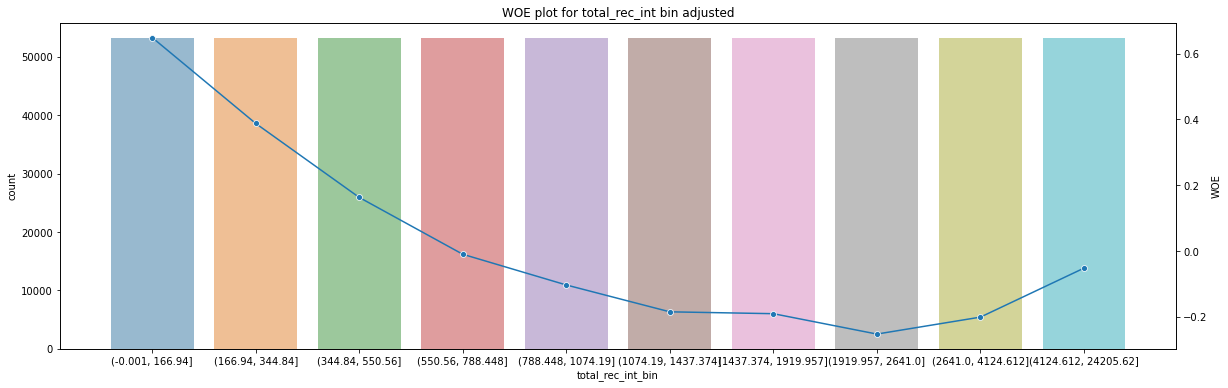

In [34]:
# 6. total_rec_int

variable = 'total_rec_int'

########
# BEFORE
########

# # # step 1 show the col in 10 bins
raw_data[variable+'_bin'] = pd.qcut(raw_data[variable],q= 10)

# # step 2
total_rec_int = pd.DataFrame()
total_rec_int[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
total_rec_int['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
total_rec_int['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
total_rec_int['Non_Events'] = total_rec_int['count'] - total_rec_int['Events']
total_rec_int['total_distri'] = total_rec_int['count']/sum(total_rec_int['count'])
total_rec_int['%_of_Events'] = total_rec_int['Events']/sum(total_rec_int['Events'])
total_rec_int['%_of_Non_Events'] = total_rec_int['Non_Events']/sum(total_rec_int['Non_Events'])
total_rec_int['WOE'] = np.log(total_rec_int['%_of_Non_Events'] / total_rec_int['%_of_Events'])
total_rec_int['IV'] = (total_rec_int['%_of_Non_Events']-total_rec_int['%_of_Events'])*total_rec_int['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = total_rec_int[variable+'_bin'] , y = total_rec_int['count'], alpha=0.5, ax = ax1)

# plot chart
ax2 = ax1.twinx()
sns.lineplot(data = total_rec_int['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for funded_amnt bin adjusted')

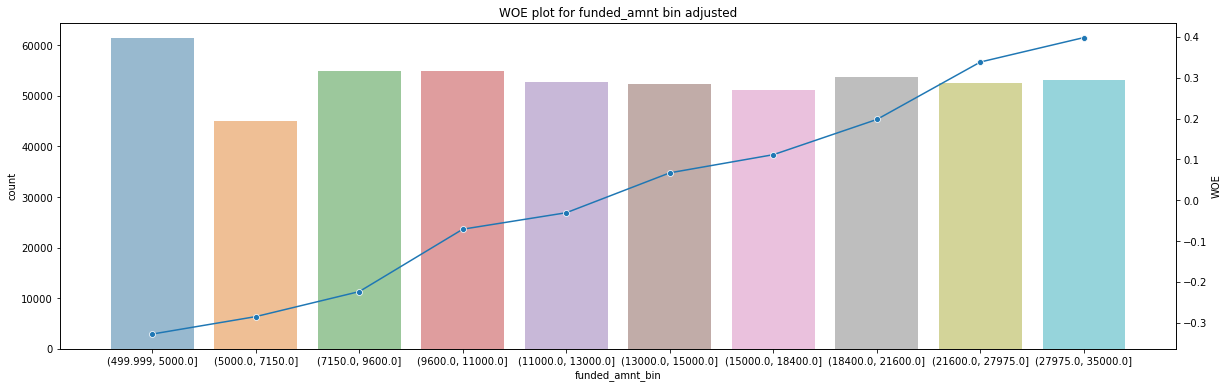

In [35]:
# 7. funded_amnt

variable = 'funded_amnt'

########
# BEFORE
########

# # # step 1 show the col in 10 bins
raw_data[variable+'_bin'] = pd.qcut(raw_data[variable],q= 10)

# # step 2
funded_amnt = pd.DataFrame()
funded_amnt[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
funded_amnt['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
funded_amnt['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
funded_amnt['Non_Events'] = funded_amnt['count'] - funded_amnt['Events']
funded_amnt['total_distri'] = funded_amnt['count']/sum(funded_amnt['count'])
funded_amnt['%_of_Events'] = funded_amnt['Events']/sum(funded_amnt['Events'])
funded_amnt['%_of_Non_Events'] = funded_amnt['Non_Events']/sum(funded_amnt['Non_Events'])
funded_amnt['WOE'] = np.log(funded_amnt['%_of_Non_Events'] / funded_amnt['%_of_Events'])
funded_amnt['IV'] = (funded_amnt['%_of_Non_Events']-funded_amnt['%_of_Events'])*funded_amnt['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = funded_amnt[variable+'_bin'] , y = funded_amnt['count'], alpha=0.5, ax = ax1)

# plot chart
ax2 = ax1.twinx()
sns.lineplot(data = funded_amnt['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for inq_last_6mths bin adjusted')

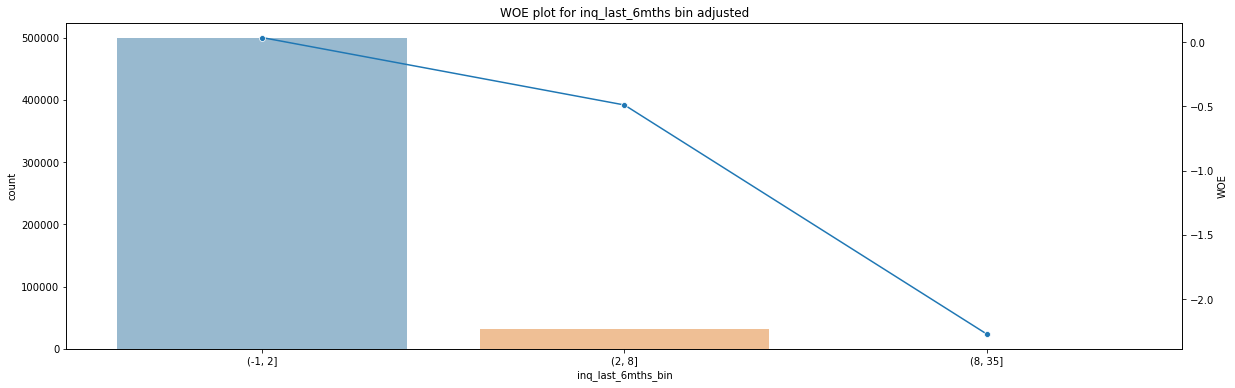

In [36]:
# 8. inq_last_6mths

variable = 'inq_last_6mths'

raw_data[variable].fillna(0,inplace=True)
#fill with 0 as we assuume that blanks means no inquiries were made

########
# BEFORE
########

# # # # # step 1 show the col in 10 bins
bin_edges = [-1,2,8,35] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # # step 2
inq_last_6mths = pd.DataFrame()
inq_last_6mths[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
inq_last_6mths['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
inq_last_6mths['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
inq_last_6mths['Non_Events'] = inq_last_6mths['count'] - inq_last_6mths['Events']
inq_last_6mths['total_distri'] = inq_last_6mths['count']/sum(inq_last_6mths['count'])
inq_last_6mths['%_of_Events'] = inq_last_6mths['Events']/sum(inq_last_6mths['Events'])
inq_last_6mths['%_of_Non_Events'] = inq_last_6mths['Non_Events']/sum(inq_last_6mths['Non_Events'])
inq_last_6mths['WOE'] = np.log(inq_last_6mths['%_of_Non_Events'] / inq_last_6mths['%_of_Events'])
inq_last_6mths['IV'] = (inq_last_6mths['%_of_Non_Events']-inq_last_6mths['%_of_Events'])*inq_last_6mths['WOE']


# # # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = inq_last_6mths[variable+'_bin'] , y = inq_last_6mths['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = inq_last_6mths['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for sub_grade bin adjusted')

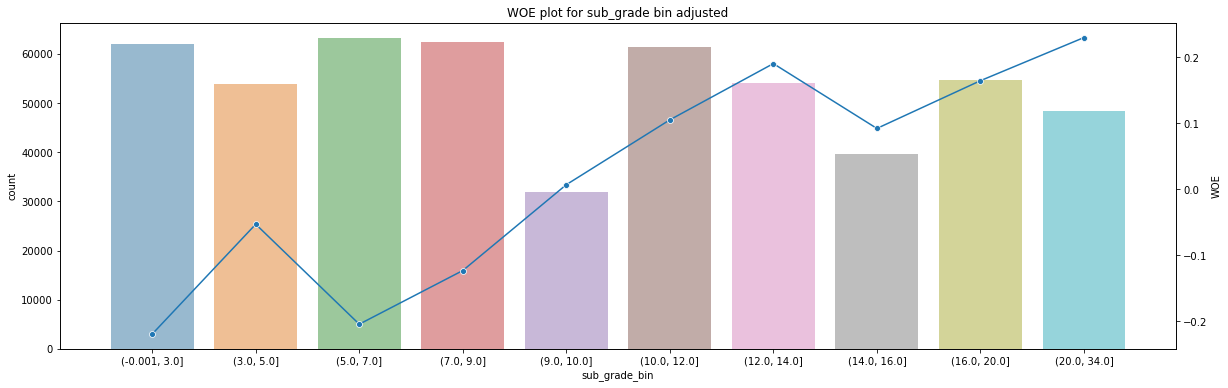

In [37]:
# 9. sub_grade

variable = 'sub_grade'

########
# BEFORE
########

# # # step 1 show the col in 10 bins
raw_data[variable+'_bin'] = pd.qcut(raw_data[variable],q= 10)
# raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
sub_grade = pd.DataFrame()
sub_grade[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
sub_grade['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
sub_grade['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
sub_grade['Non_Events'] = sub_grade['count'] - sub_grade['Events']
sub_grade['total_distri'] = sub_grade['count']/sum(sub_grade['count'])
sub_grade['%_of_Events'] = sub_grade['Events']/sum(sub_grade['Events'])
sub_grade['%_of_Non_Events'] = sub_grade['Non_Events']/sum(sub_grade['Non_Events'])
sub_grade['WOE'] = np.log(sub_grade['%_of_Non_Events'] / sub_grade['%_of_Events'])
sub_grade['IV'] = (sub_grade['%_of_Non_Events']-sub_grade['%_of_Events'])*sub_grade['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = sub_grade[variable+'_bin'] , y = sub_grade['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = sub_grade['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for verification_status bin adjusted')

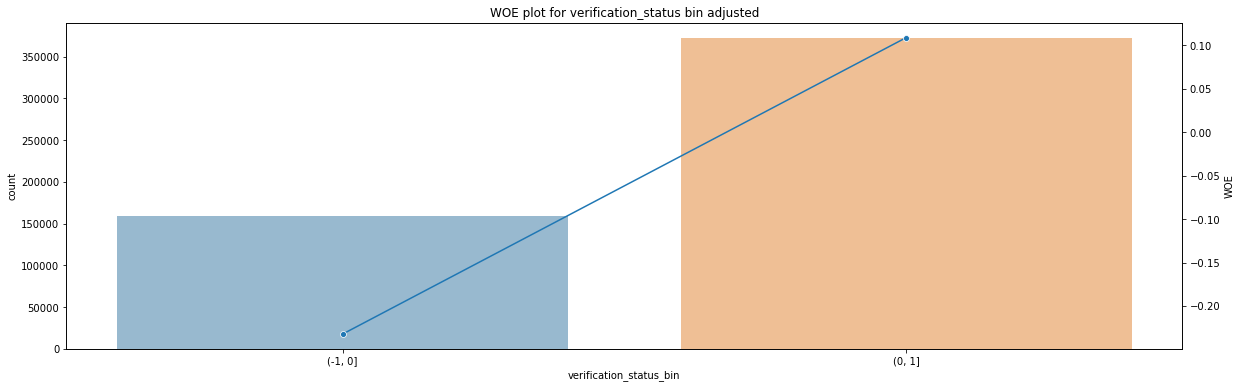

In [38]:
# 10. verification_status

variable = 'verification_status'


########
# BEFORE
########

# # # step 1 show the col in 10 bins
bin_edges = [-1,0,1] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
verification_status = pd.DataFrame()
verification_status[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
verification_status['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
verification_status['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
verification_status['Non_Events'] = verification_status['count'] - verification_status['Events']
verification_status['total_distri'] = verification_status['count']/sum(verification_status['count'])
verification_status['%_of_Events'] = verification_status['Events']/sum(verification_status['Events'])
verification_status['%_of_Non_Events'] = verification_status['Non_Events']/sum(verification_status['Non_Events'])
verification_status['WOE'] = np.log(verification_status['%_of_Non_Events'] / verification_status['%_of_Events'])
verification_status['IV'] = (verification_status['%_of_Non_Events']-verification_status['%_of_Events'])*verification_status['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = verification_status[variable+'_bin'] , y = verification_status['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = verification_status['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for revol_bal bin adjusted')

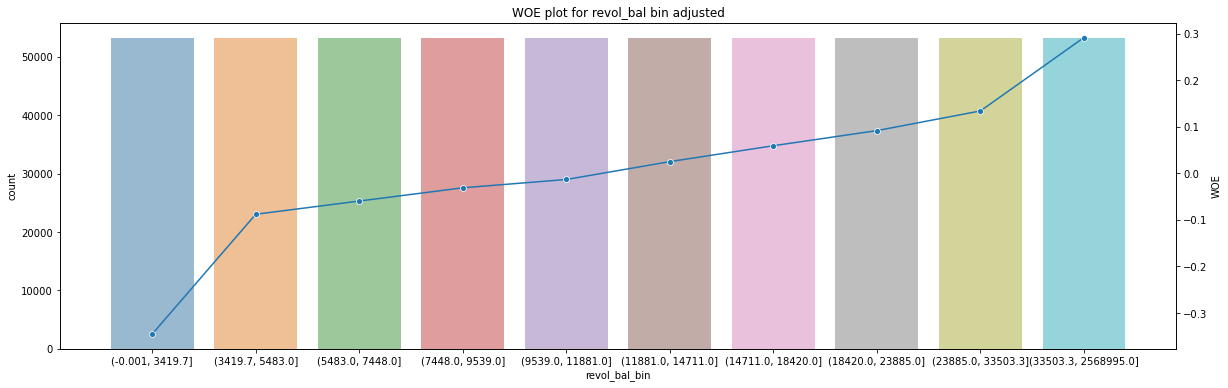

In [39]:
# 11. revol_bal

variable = 'revol_bal'

########
# BEFORE
########

# # # step 1 show the col in 10 bins
raw_data[variable+'_bin'] = pd.qcut(raw_data[variable],q= 10)

# # step 2
revol_bal = pd.DataFrame()
revol_bal[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
revol_bal['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
revol_bal['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
revol_bal['Non_Events'] = revol_bal['count'] - revol_bal['Events']
revol_bal['total_distri'] = revol_bal['count']/sum(revol_bal['count'])
revol_bal['%_of_Events'] = revol_bal['Events']/sum(revol_bal['Events'])
revol_bal['%_of_Non_Events'] = revol_bal['Non_Events']/sum(revol_bal['Non_Events'])
revol_bal['WOE'] = np.log(revol_bal['%_of_Non_Events'] / revol_bal['%_of_Events'])
revol_bal['IV'] = (revol_bal['%_of_Non_Events']-revol_bal['%_of_Events'])*revol_bal['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = revol_bal[variable+'_bin'] , y = revol_bal['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = revol_bal['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for open_acc bin adjusted')

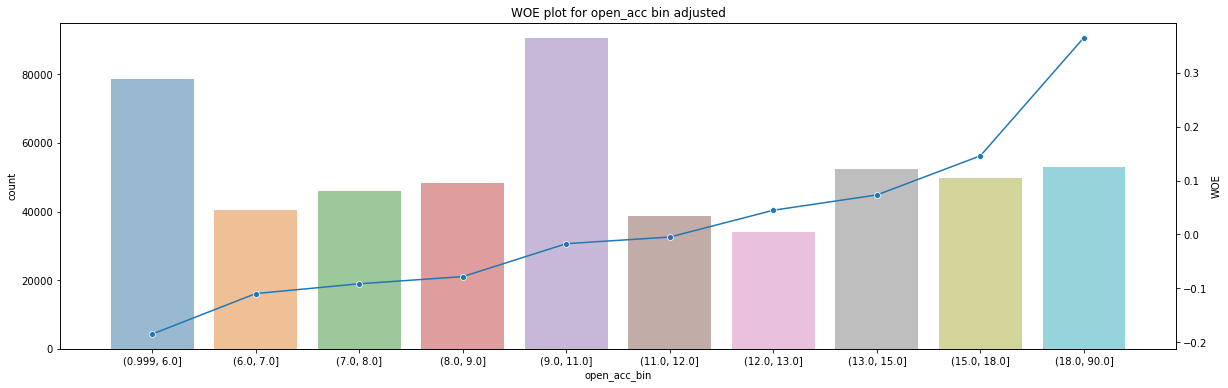

In [40]:
# 12. open_acc

variable = 'open_acc'

raw_data[variable].fillna(0,inplace=True)
#fill with 0 as we assume that blanks means that there is 0 open accounts

########
# BEFORE
########

# # # step 1 show the col in 10 bins
raw_data[variable+'_bin'] = pd.qcut(raw_data[variable],q= 10)

# # step 2
open_acc = pd.DataFrame()
open_acc[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
open_acc['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
open_acc['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
open_acc['Non_Events'] = open_acc['count'] - open_acc['Events']
open_acc['total_distri'] = open_acc['count']/sum(open_acc['count'])
open_acc['%_of_Events'] = open_acc['Events']/sum(open_acc['Events'])
open_acc['%_of_Non_Events'] = open_acc['Non_Events']/sum(open_acc['Non_Events'])
open_acc['WOE'] = np.log(open_acc['%_of_Non_Events'] / open_acc['%_of_Events'])
open_acc['IV'] = (open_acc['%_of_Non_Events']-open_acc['%_of_Events'])*open_acc['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = open_acc[variable+'_bin'] , y = open_acc['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = open_acc['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

##### Rebin columns

Text(0.5, 1.0, 'WOE plot for last_week_pay bin adjusted')

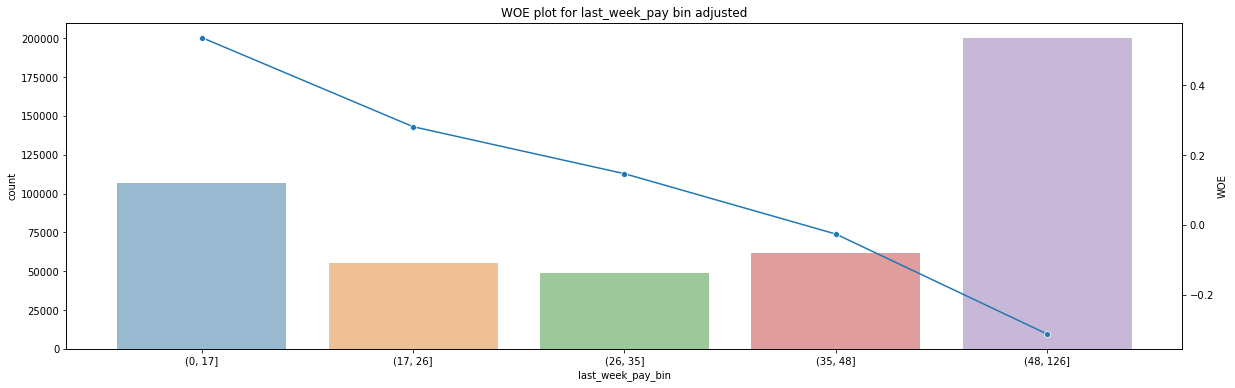

In [41]:
# 1. last_week_pay

variable = 'last_week_pay'

########
# AFTER
########

# # # step 1 show the col in new bins
bin_edges = [0, 17,26,35,48,126] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)


# # step 2
last_week_pay = pd.DataFrame()
last_week_pay['last_week_pay_bin'] = raw_data.groupby(by='last_week_pay_bin', as_index=False).count()['last_week_pay_bin']
last_week_pay['count'] = raw_data.groupby(by='last_week_pay_bin', as_index=False).count()['loan_status']
last_week_pay['Events'] = raw_data.groupby(by='last_week_pay_bin', as_index=False).sum()['loan_status']
last_week_pay['Non_Events'] = last_week_pay['count'] - last_week_pay['Events']
last_week_pay['total_distri'] = last_week_pay['count']/sum(last_week_pay['count'])
last_week_pay['%_of_Events'] = last_week_pay['Events']/sum(last_week_pay['Events'])
last_week_pay['%_of_Non_Events'] = last_week_pay['Non_Events']/sum(last_week_pay['Non_Events'])
last_week_pay['WOE'] = np.log(last_week_pay['%_of_Non_Events'] / last_week_pay['%_of_Events'])
last_week_pay['IV'] = (last_week_pay['%_of_Non_Events']-last_week_pay['%_of_Events'])*last_week_pay['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = last_week_pay['last_week_pay_bin'] , y = last_week_pay['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = last_week_pay['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for last_week_pay bin adjusted")

Text(0.5, 1.0, 'WOE plot for dti bin adjusted')

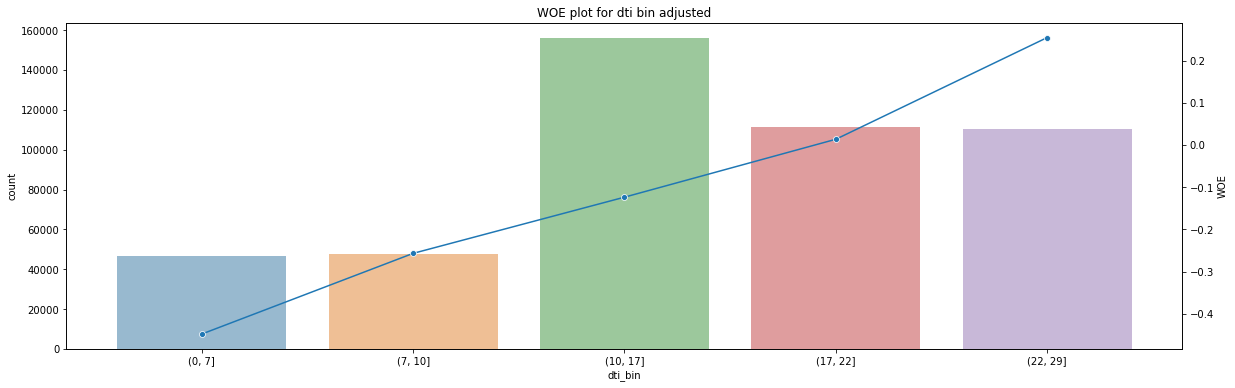

In [42]:
# 3. dti

variable = 'dti'

########
# AFTER
########

# step 1 show the col in new bins
bin_edges = [0,7,10,17,22,29] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
dti = pd.DataFrame()
dti['dti_bin'] = raw_data.groupby(by='dti_bin', as_index=False).count()['dti_bin']
dti['count'] = raw_data.groupby(by='dti_bin', as_index=False).count()['loan_status']
dti['Events'] = raw_data.groupby(by='dti_bin', as_index=False).sum()['loan_status']
dti['Non_Events'] = dti['count'] - dti['Events']
dti['total_distri'] = dti['count']/sum(dti['count'])
dti['%_of_Events'] = dti['Events']/sum(dti['Events'])
dti['%_of_Non_Events'] = dti['Non_Events']/sum(last_week_pay['Non_Events'])
dti['WOE'] = np.log(dti['%_of_Non_Events'] / dti['%_of_Events'])
dti['IV'] = (dti['%_of_Non_Events']-dti['%_of_Events'])*dti['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = dti['dti_bin'] , y = dti['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = dti['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for dti bin adjusted")

Text(0.5, 1.0, 'WOE plot for total_rec_int bin adjusted')

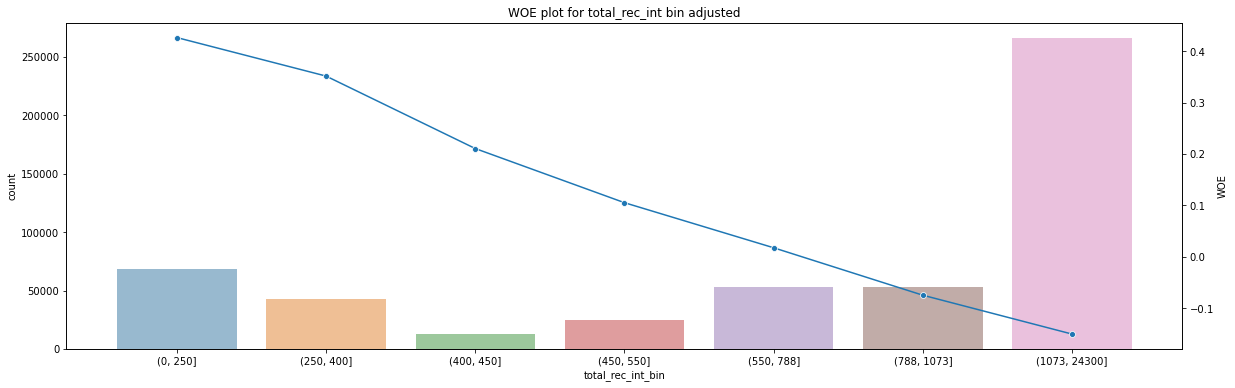

In [43]:
# 6. total_rec_int

variable = 'total_rec_int'

########
# AFTER
########

# step 1 show the col in new bins
bin_edges = [0, 250, 400, 450, 550, 788, 1073, 24300]
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
total_rec_int = pd.DataFrame()
total_rec_int[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
total_rec_int['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
total_rec_int['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
total_rec_int['Non_Events'] = total_rec_int['count'] - total_rec_int['Events']
total_rec_int['total_distri'] = total_rec_int['count']/sum(total_rec_int['count'])
total_rec_int['%_of_Events'] = total_rec_int['Events']/sum(total_rec_int['Events'])
total_rec_int['%_of_Non_Events'] = total_rec_int['Non_Events']/sum(total_rec_int['Non_Events'])
total_rec_int['WOE'] = np.log(total_rec_int['%_of_Non_Events'] / total_rec_int['%_of_Events'])
total_rec_int['IV'] = (total_rec_int['%_of_Non_Events']-total_rec_int['%_of_Events'])*total_rec_int['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = total_rec_int[variable+'_bin'] , y = total_rec_int['count'], alpha=0.5, ax = ax1)

# plot chart
ax2 = ax1.twinx()
sns.lineplot(data = total_rec_int['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for funded_amnt bin adjusted')

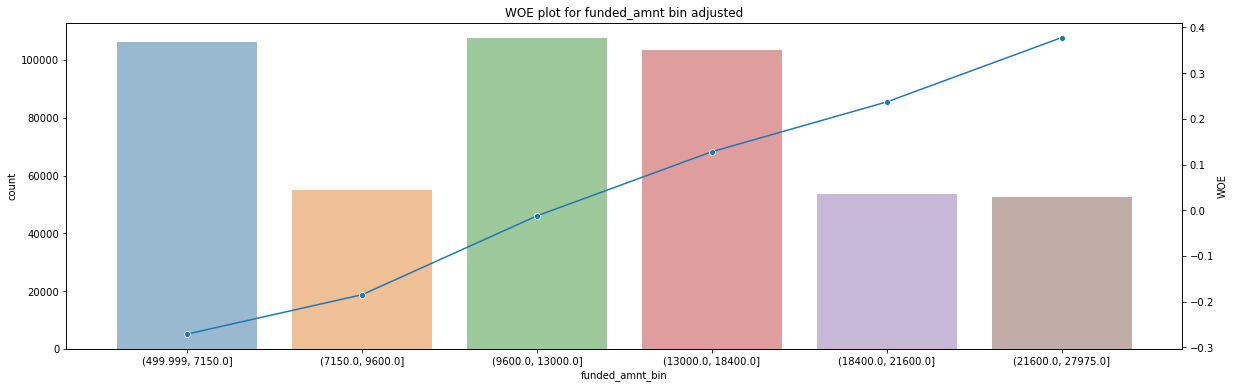

In [44]:
# 7. funded_amnt

variable = 'funded_amnt'

########
# AFTER
########

# step 1 show the col in new bins
bin_edges = [499.999,7150,9600,13000,18400,21600, 27975]
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
funded_amnt = pd.DataFrame()
funded_amnt[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
funded_amnt['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
funded_amnt['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
funded_amnt['Non_Events'] = funded_amnt['count'] - funded_amnt['Events']
funded_amnt['total_distri'] = funded_amnt['count']/sum(funded_amnt['count'])
funded_amnt['%_of_Events'] = funded_amnt['Events']/sum(funded_amnt['Events'])
funded_amnt['%_of_Non_Events'] = funded_amnt['Non_Events']/sum(funded_amnt['Non_Events'])
funded_amnt['WOE'] = np.log(funded_amnt['%_of_Non_Events'] / funded_amnt['%_of_Events'])
funded_amnt['IV'] = (funded_amnt['%_of_Non_Events']-funded_amnt['%_of_Events'])*funded_amnt['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = funded_amnt[variable+'_bin'] , y = funded_amnt['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = funded_amnt['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for sub_grade bin adjusted')

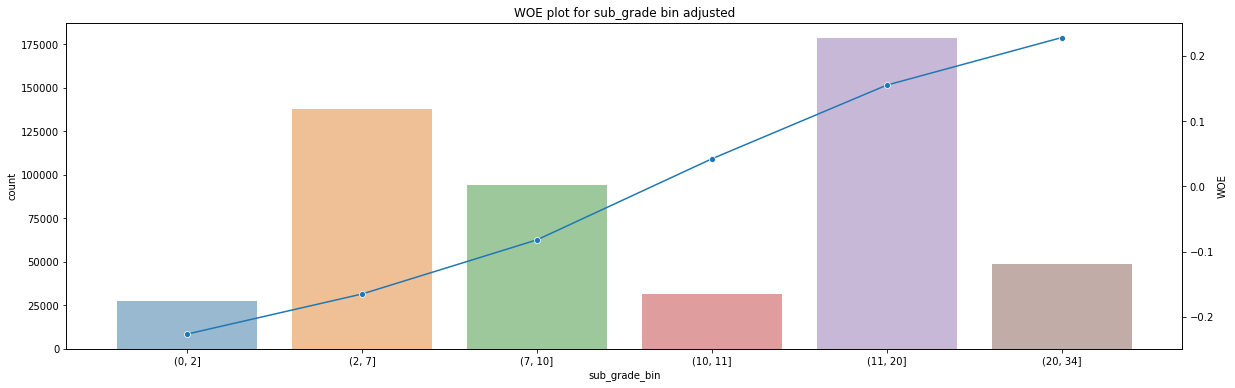

In [45]:
# 9. sub_grade

variable = 'sub_grade'

########
# AFTER
########

# step 1 show the col in new bins
bin_edges = [0, 2, 7, 10, 11, 20, 34] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
sub_grade = pd.DataFrame()
sub_grade[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
sub_grade['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
sub_grade['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
sub_grade['Non_Events'] = sub_grade['count'] - sub_grade['Events']
sub_grade['total_distri'] = sub_grade['count']/sum(sub_grade['count'])
sub_grade['%_of_Events'] = sub_grade['Events']/sum(sub_grade['Events'])
sub_grade['%_of_Non_Events'] = sub_grade['Non_Events']/sum(sub_grade['Non_Events'])
sub_grade['WOE'] = np.log(sub_grade['%_of_Non_Events'] / sub_grade['%_of_Events'])
sub_grade['IV'] = (sub_grade['%_of_Non_Events']-sub_grade['%_of_Events'])*sub_grade['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = sub_grade[variable+'_bin'] , y = sub_grade['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = sub_grade['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for revol_bal bin adjusted')

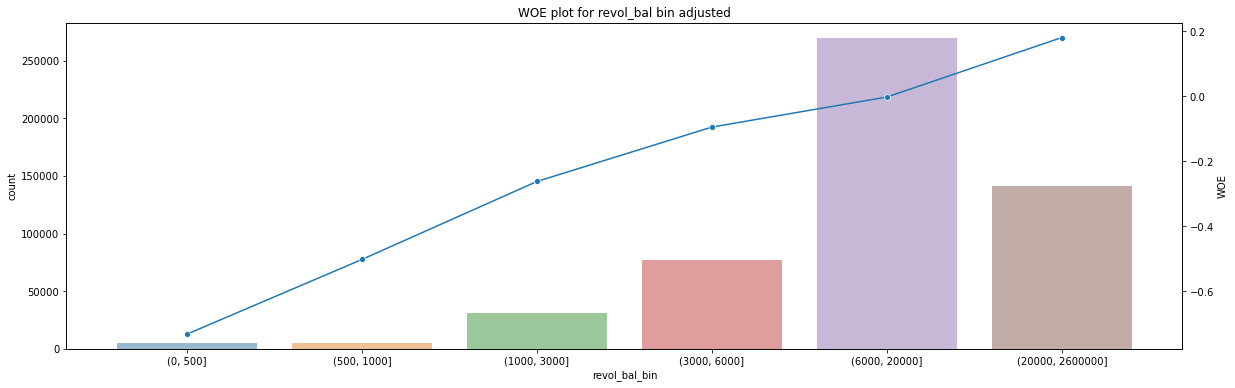

In [46]:
# 11. revol_bal

variable = 'revol_bal'

########
# AFTER
########

# step 1 show the col in new bins
bin_edges = [0, 500, 1000, 3000, 6000, 20000, 2600000] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
revol_bal = pd.DataFrame()
revol_bal[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
revol_bal['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
revol_bal['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
revol_bal['Non_Events'] = revol_bal['count'] - revol_bal['Events']
revol_bal['total_distri'] = revol_bal['count']/sum(revol_bal['count'])
revol_bal['%_of_Events'] = revol_bal['Events']/sum(revol_bal['Events'])
revol_bal['%_of_Non_Events'] = revol_bal['Non_Events']/sum(revol_bal['Non_Events'])
revol_bal['WOE'] = np.log(revol_bal['%_of_Non_Events'] / revol_bal['%_of_Events'])
revol_bal['IV'] = (revol_bal['%_of_Non_Events']-revol_bal['%_of_Events'])*revol_bal['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = revol_bal[variable+'_bin'] , y = revol_bal['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = revol_bal['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

Text(0.5, 1.0, 'WOE plot for open_acc bin adjusted')

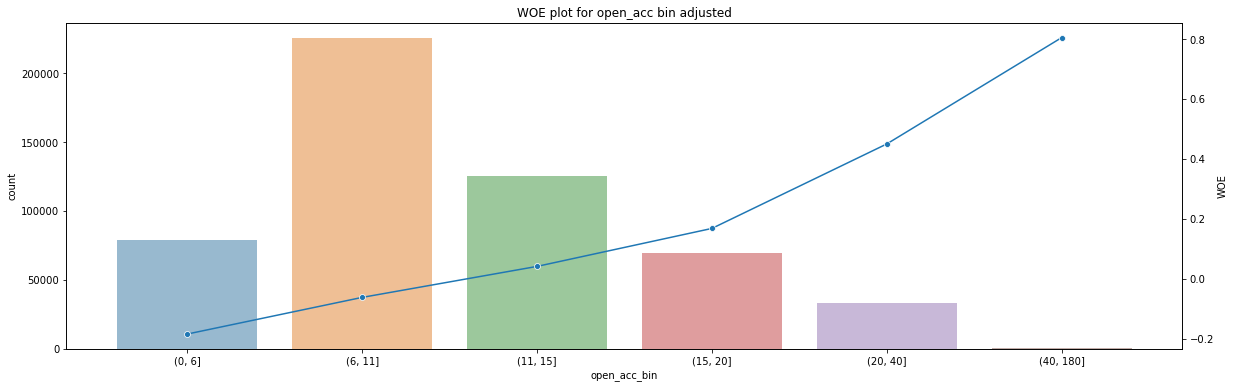

In [47]:
# 12. open_acc

variable = 'open_acc'

########
# AFTER
########

# step 1 show the col in new bins
bin_edges = [0, 6, 11, 15, 20, 40, 180] 
raw_data[variable+'_bin'] = pd.cut(raw_data[variable], bins = bin_edges)

# # step 2
open_acc = pd.DataFrame()
open_acc[variable+'_bin'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()[variable+'_bin']
open_acc['count'] = raw_data.groupby(by=variable+'_bin', as_index=False).count()['loan_status']
open_acc['Events'] = raw_data.groupby(by=variable+'_bin', as_index=False).sum()['loan_status']
open_acc['Non_Events'] = open_acc['count'] - open_acc['Events']
open_acc['total_distri'] = open_acc['count']/sum(open_acc['count'])
open_acc['%_of_Events'] = open_acc['Events']/sum(open_acc['Events'])
open_acc['%_of_Non_Events'] = open_acc['Non_Events']/sum(open_acc['Non_Events'])
open_acc['WOE'] = np.log(open_acc['%_of_Non_Events'] / open_acc['%_of_Events'])
open_acc['IV'] = (open_acc['%_of_Non_Events']-open_acc['%_of_Events'])*open_acc['WOE']


# # step 3 display chart
fig, ax1 = plt.subplots(figsize=(20,6))
sns.barplot(x = open_acc[variable+'_bin'] , y = open_acc['count'], alpha=0.5, ax = ax1)

ax2 = ax1.twinx()
sns.lineplot(data = open_acc['WOE'], marker='o', sort = False, ax=ax2)
plt.title("WOE plot for "+variable+" bin adjusted")

In [48]:
# # get the new IV
iv_df, woe_df = iv_woe(raw_data, "loan_status")
iv_df.sort_values(by='IV', ascending=False).round(4)

,Variable,IV
0,last_week_pay,0.3838
0,initial_list_status,0.3086
0,initial_list_status_bin,0.3086
0,last_week_pay_bin,0.1113
0,dti,0.1080
0,term_bin,0.1047
0,term,0.1047
0,total_rec_int,0.0707
0,funded_amnt,0.0567
0,funded_amnt_bin,0.0450


#### Logistic Regression

In [49]:
# #Splitting the columns, X -> independent variables ,, y-> dependent variable
# raw_data.info()

X = raw_data[['last_week_pay', 'initial_list_status', 'dti', 'term', 'total_rec_int', 'funded_amnt',
              'inq_last_6mths', 'sub_grade', 'verification_status', 'revol_bal', 'open_acc', 
              'mths_since_last_record']]

y = raw_data['loan_status']

#Create a train set and test set from the data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.30,random_state=0)

#Generate the logistic regression fit using training data
lr = LogisticRegression(max_iter = 4000)
lr.fit(X_train,y_train)

#Print the intercept and coefficients
b0 = lr.intercept_
b_coeff = lr.coef_

print('Intercept = ',b0, '\nCoefficients = ',b_coeff)

Intercept =  [-0.00182538] 
Coefficients =  [[ 1.36263470e-02 -1.40160383e-02 -3.64520628e-02 -3.65572001e-02
  -5.91368330e-05 -4.23287223e-06  1.32880099e-02  2.02983052e-02
  -2.20708054e-03  1.49823102e-07 -4.36169757e-03  6.86728457e-04]]


#### Logistic Regression Accuracy

In [50]:
# # method 1
y_pred = lr.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

# # method 2
score = LogisticRegression.score(lr,X_test, y_test)
print(score)

Accuracy of logistic regression classifier on test set: 0.78
0.7841934998495336


In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

#this means we have (118092 + 3540) correct predictions and (30765 + 7107 wrong predictions)

[[117772   3853]
 [ 30569   7310]]


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.97      0.87    121625
           1       0.65      0.19      0.30     37879

    accuracy                           0.78    159504
   macro avg       0.72      0.58      0.59    159504
weighted avg       0.76      0.78      0.74    159504



# METHOD 2: SCORECARDPY

In [53]:
###############
# SCORECARDPY #
###############

In [54]:
# !pip install git+git://github.com/shichenxie/scorecardpy.git
import scorecardpy as sc
import pprint

#### DATA

In [55]:
raw_data = pd.read_csv('train_indessa.csv')

#### PRE-PROCESSING

In [56]:
#first drop - remove rows with 'JOINT' under application type (too little values: 305)
raw_data = raw_data[raw_data.application_type != 'JOINT']


#second drop - drop rows with missing values for certain variables (less than 300)
raw_data = raw_data.dropna(subset=['annual_inc', 'title', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
                                   'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'acc_now_delinq'])

#third drop - retain rows with at least 20 non-null values
raw_data.dropna(thresh= 20, inplace = True)


#fourth drop - remove columns that are not useful for prediction
raw_data = raw_data.drop(columns=['member_id', 'batch_enrolled', 'verification_status_joint'])
raw_data = raw_data.drop(columns=['emp_title','desc','title','zip_code','addr_state', 'application_type'])

# REMOVED COLUMNS 
# member_id - unique value given by the bank to each member
# batch_enrolled - batch number given by the bank to each member
# verification_status_joint - only for joint accounts, however insignificant number of joint accounts
# emp_title - too many unique values
# desc - same as purpose
# title - same as purpose
# zip_code - replace by home ownership
# addr_state - replace by home ownership
# application_type - very little joints
#################

raw_raw_data = raw_data.copy()

#fifth drop - remove highly correlated columns to counter multicollinearity  (>=0.8)
raw_data = raw_data.drop(columns=['loan_amnt','funded_amnt_inv','total_rev_hi_lim','recoveries', 'grade',
                                 'int_rate'])

#### Encode Strings to Int

In [57]:
#########################
# ENCODE strings to int
#########################

# ###### term ######
# sort by term, 36 months = 36, 60 months = 60
def encode_term(x):
    if x == '36 months':
        return 36
    elif x == '60 months':
        return 60

raw_data['term']  = raw_data['term'].apply(encode_term)

###### sub_grade ######
# sort by asc sub_grade so A1 = 0 ,A2 = 1,...
raw_data = raw_data.sort_values(by=['sub_grade'])
labels2, levels2 = pd.factorize(raw_data['sub_grade'])
raw_data['sub_grade'] = labels2

# ###### emp_length ######
raw_data['emp_length'] = raw_data['emp_length'].str.extract('(\d+)').astype(float)
raw_data['emp_length'].fillna(0,inplace=True)

# ###### home_ownership ######
# # sort by asc home_ownership, alphabetical order of 'home_ownership' first char a=0,..., z=26
raw_data = raw_data.sort_values(by=['home_ownership'])
labels3, levels3 = pd.factorize(raw_data['home_ownership'])
raw_data['home_ownership'] = labels3

###### verification_status ######
# sort by asc verification_status, Not Verified = 0,  Verified and Source Verified = 1
def encode_verification_status(x):
    if x == 'Not Verified':
        return 0
    elif x == 'Verified':
        return 1
    elif x == 'Source Verified':
        return 1
raw_data['verification_status']  = raw_data['verification_status'].apply(encode_verification_status)

###### pymnt_plan ######
# sort by asc pymnt_plan, n = 0,  y = 1
def encode_pymnt_plan(x):
    if x == 'n':
        return 0
    elif x == 'y':
        return 1
raw_data['pymnt_plan']  = raw_data['pymnt_plan'].apply(encode_pymnt_plan)

# ###### purpose ######
# # sort by asc purpose, alphabetical order of 'purpose' first char a=0,..., z=26
raw_data = raw_data.sort_values(by=['purpose'])
labels4, levels4 = pd.factorize(raw_data['purpose'])
raw_data['purpose'] = labels4

# ###### initial_list_status ######
# # sort by asc initial_list_status , f = 0, w =1
raw_data = raw_data.sort_values(by=['initial_list_status'])
labels5, levels5 = pd.factorize(raw_data['initial_list_status'])
raw_data['initial_list_status'] = labels5

# ###### last_week_pay ######
raw_data['last_week_pay'] = raw_data['last_week_pay'].str.extract('(\d+)').astype(float)
raw_data['last_week_pay'].fillna(0,inplace=True)

# ###### mths_since_last_major_derog  ######
max_value = raw_data['mths_since_last_major_derog'].max()
max_value *= 2
raw_data['mths_since_last_major_derog'].fillna(max_value,inplace=True)

# ###### mths_since_last_delinq   ######
max_value = raw_data['mths_since_last_delinq'].max()
max_value *= 2
raw_data['mths_since_last_delinq'].fillna(max_value,inplace=True)

# ###### mths_since_last_record   ######
max_value = raw_data['mths_since_last_record'].max()
max_value *= 2
raw_data['mths_since_last_record'].fillna(max_value,inplace=True)
raw_data.isna().sum()

# ###### delinq_2yrs   ######
raw_data['delinq_2yrs'].fillna(0,inplace=True)

# ###### total_acc   ######
raw_data['total_acc'].fillna(0,inplace=True)

# ###### tot_coll_amt   ######
raw_data['tot_coll_amt'].fillna(0,inplace=True)

# ###### tot_cur_bal   ######
raw_data['tot_cur_bal'].fillna(0,inplace=True)

# ###### total_rec_late_fee   ######
raw_data['total_rec_late_fee'] = raw_data['total_rec_late_fee'].astype(float)

# ###### collection_recovery_fee   ######
raw_data['collection_recovery_fee'] = raw_data['collection_recovery_fee'].astype(int)

# # check if properly encoded
raw_data[['term','sub_grade', 'emp_length', 'home_ownership','verification_status','purpose',
          'initial_list_status','last_week_pay','mths_since_last_major_derog','mths_since_last_delinq',
          'delinq_2yrs','total_acc', 'open_acc']].head()

,term,sub_grade,emp_length,home_ownership,verification_status,purpose,initial_list_status,last_week_pay,mths_since_last_major_derog,mths_since_last_delinq,delinq_2yrs,total_acc,open_acc
137930,36,9,1.0,5,1,13,0,104.0,360.0,360.0,0.0,31.0,10.0
443269,36,10,5.0,5,1,2,0,13.0,360.0,59.0,0.0,7.0,4.0
222613,36,4,10.0,1,0,2,0,9.0,360.0,360.0,0.0,8.0,5.0
214074,36,10,4.0,5,1,2,0,135.0,360.0,360.0,0.0,29.0,17.0
351192,60,10,1.0,5,1,2,0,113.0,360.0,10.0,4.0,43.0,8.0


In [58]:
raw_data

,funded_amnt,term,sub_grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,dti,...,total_rec_int,total_rec_late_fee,collection_recovery_fee,collections_12_mths_ex_med,mths_since_last_major_derog,last_week_pay,acc_now_delinq,tot_coll_amt,tot_cur_bal,loan_status
137930,12000,36,9,1.0,5,104000.0,1,0,13,15.33,...,2425.87,0.000000,0,0.0,360.0,104.0,0.0,0.0,46616.0,1
443269,10000,36,10,5.0,5,43680.0,1,0,2,10.96,...,293.29,0.000000,0,0.0,360.0,13.0,0.0,1498.0,21029.0,0
222613,5600,36,4,10.0,1,40000.0,0,0,2,8.70,...,67.82,0.000000,0,0.0,360.0,9.0,0.0,0.0,96120.0,0
214074,15000,36,10,4.0,5,38000.0,1,0,2,27.13,...,3364.73,0.000000,0,0.0,360.0,135.0,0.0,0.0,0.0,0
351192,12950,60,10,1.0,5,85000.0,1,0,2,14.91,...,3111.08,29.972902,0,0.0,360.0,113.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456104,3500,36,6,1.0,5,55000.0,0,0,2,21.03,...,322.95,0.000000,0,0.0,360.0,61.0,0.0,125.0,162501.0,1
94146,20000,60,12,3.0,5,55000.0,1,0,2,20.05,...,1322.66,0.000000,0,0.0,25.0,26.0,0.0,0.0,82782.0,0
305055,7925,36,5,8.0,5,55000.0,1,0,2,26.44,...,790.66,0.000000,0,0.0,360.0,65.0,0.0,0.0,37491.0,1
94043,5000,36,12,1.0,5,53000.0,0,0,2,6.45,...,785.73,0.000000,0,0.0,42.0,70.0,0.0,249.0,25989.0,1


#### Get Columns IV

In [59]:
bins = sc.woebin(raw_data, y='loan_status',sort=False)
print(bins)

[INFO] creating woe binning ...
Binning on 531678 rows and 30 columns in 00:00:48
{'collections_12_mths_ex_med':                      variable         bin   count  count_distr    good  \
0  collections_12_mths_ex_med  [-inf,inf)  531678          1.0  406013   

      bad   badprob  woe  bin_iv  total_iv breaks  is_special_values  
0  125665  0.236355  0.0     0.0       0.0    inf              False  , 'open_acc':    variable          bin   count  count_distr    good    bad   badprob  \
0  open_acc   [-inf,6.0)   45222     0.085055   32697  12525  0.276967   
1  open_acc   [6.0,10.0)  168216     0.316387  125247  42969  0.255439   
2  open_acc  [10.0,15.0)  191849     0.360837  146719  45130  0.235237   
3  open_acc  [15.0,21.0)   93036     0.174986   73477  19559  0.210230   
4  open_acc   [21.0,inf)   33355     0.062735   27873   5482  0.164353   

        woe    bin_iv  total_iv breaks  is_special_values  
0  0.213209  0.004080  0.022705    6.0              False  
1  0.102957  0.003

In [60]:
for variables , bindetails in bins.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

collections_12_mths_ex_med  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,collections_12_mths_ex_med,"[-inf,inf)",531678,1.0,406013,125665,0.236355,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
open_acc  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,open_acc,"[-inf,6.0)",45222,0.085055,32697,12525,0.276967,0.213209,0.004080,0.022705,6.0,False
1,open_acc,"[6.0,10.0)",168216,0.316387,125247,42969,0.255439,0.102957,0.003444,0.022705,10.0,False
2,open_acc,"[10.0,15.0)",191849,0.360837,146719,45130,0.235237,-0.006206,0.000014,0.022705,15.0,False
3,open_acc,"[15.0,21.0)",93036,0.174986,73477,19559,0.210230,-0.150771,0.003819,0.022705,21.0,False
4,open_acc,"[21.0,inf)",33355,0.062735,27873,5482,0.164353,-0.453423,0.011348,0.022705,inf,False


----------------------------------------------------------------------------------------------------
total_acc  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,total_acc,"[-inf,10.0)",30304,0.056997,22694,7610,0.251122,0.080128,0.000374,0.000576,10.0,False
1,total_acc,"[10.0,24.0)",233096,0.438416,178278,54818,0.235173,-0.006560,0.000019,0.000576,24.0,False
2,total_acc,"[24.0,26.0)",36425,0.068510,28077,8348,0.229183,-0.040163,0.000109,0.000576,26.0,False
3,total_acc,"[26.0,28.0)",33745,0.063469,25945,7800,0.231145,-0.029090,0.000053,0.000576,28.0,False
4,total_acc,"[28.0,inf)",198108,0.372609,151019,47089,0.237694,0.007399,0.000020,0.000576,inf,False


----------------------------------------------------------------------------------------------------
acc_now_delinq  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,acc_now_delinq,"[-inf,inf)",531678,1.0,406013,125665,0.236355,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
verification_status  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,verification_status,"[-inf,1.0)",159707,0.300383,114859,44848,0.280814,0.232339,0.017191,0.025248,1.0,False
1,verification_status,"[1.0,inf)",371971,0.699617,291154,80817,0.217267,-0.108899,0.008058,0.025248,inf,False


----------------------------------------------------------------------------------------------------
annual_inc  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,annual_inc,"[-inf,30000.0)",30109,0.056630,23071,7038,0.233751,-0.014487,0.000012,0.001169,30000.0,False
1,annual_inc,"[30000.0,100000.0)",396902,0.746508,301983,94919,0.239150,0.015419,0.000178,0.001169,100000.0,False
2,annual_inc,"[100000.0,150000.0)",73839,0.138879,56744,17095,0.231517,-0.026998,0.000101,0.001169,150000.0,False
3,annual_inc,"[150000.0,inf)",30828,0.057982,24215,6613,0.214513,-0.125169,0.000878,0.001169,inf,False


----------------------------------------------------------------------------------------------------
mths_since_last_delinq  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mths_since_last_delinq,"[-inf,10.0)",36238,0.068158,29531,6707,0.185082,-0.309523,0.005993,0.016642,10.0,False
1,mths_since_last_delinq,"[10.0,20.0)",47190,0.088757,37461,9729,0.206167,-0.175424,0.002604,0.016642,20.0,False
2,mths_since_last_delinq,"[20.0,190.0)",176001,0.331029,136663,39338,0.223510,-0.072562,0.001709,0.016642,190.0,False
3,mths_since_last_delinq,"[190.0,inf)",272249,0.512056,202358,69891,0.256717,0.109664,0.006335,0.016642,inf,False


----------------------------------------------------------------------------------------------------
sub_grade  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,sub_grade,"[-inf,10.0)",241611,0.454431,177495,64116,0.265369,0.154517,0.011287,0.023424,10.0,False
1,sub_grade,"[10.0,12.0)",63252,0.118967,48587,14665,0.231850,-0.025127,0.000075,0.023424,12.0,False
2,sub_grade,"[12.0,inf)",226815,0.426602,179931,46884,0.206706,-0.172131,0.012063,0.023424,inf,False


----------------------------------------------------------------------------------------------------
revol_bal  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,revol_bal,"[-inf,3000.0)",43762,0.082309,30111,13651,0.311937,0.381688,0.013156,0.023977,3000.0,False
1,revol_bal,"[3000.0,20000.0)",346289,0.651313,263259,83030,0.239771,0.018829,0.000232,0.023977,20000.0,False
2,revol_bal,"[20000.0,36000.0)",96937,0.182323,76172,20765,0.214211,-0.126960,0.002840,0.023977,36000.0,False
3,revol_bal,"[36000.0,inf)",44690,0.084055,36471,8219,0.183911,-0.317303,0.007750,0.023977,inf,False


----------------------------------------------------------------------------------------------------
purpose  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,purpose,"[-inf,2.0)",128790,0.242233,101393,27397,0.212726,-0.135805,0.004307,0.019307,2.0,False
1,purpose,"[2.0,3.0)",314603,0.591717,241627,72976,0.231962,-0.024499,0.000353,0.019307,3.0,False
2,purpose,"[3.0,5.0)",31266,0.058806,23352,7914,0.253118,0.090716,0.000495,0.019307,5.0,False
3,purpose,"[5.0,inf)",57019,0.107243,39641,17378,0.304776,0.348107,0.014152,0.019307,inf,False


----------------------------------------------------------------------------------------------------
pub_rec  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,pub_rec,"[-inf,1.0)",450416,0.847159,340206,110210,0.244685,0.045602,0.001783,0.012574,1.0,False
1,pub_rec,"[1.0,inf)",81262,0.152841,65807,15455,0.190187,-0.276028,0.010791,0.012574,inf,False


----------------------------------------------------------------------------------------------------
mths_since_last_major_derog  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mths_since_last_major_derog,"[-inf,60.0)",96003,0.180566,78883,17120,0.178328,-0.354953,0.020606,0.042068,60.0,False
1,mths_since_last_major_derog,"[60.0,150.0)",36753,0.069126,30669,6084,0.165538,-0.444824,0.012065,0.042068,150.0,False
2,mths_since_last_major_derog,"[150.0,inf)",398922,0.750308,296461,102461,0.256845,0.110332,0.009397,0.042068,inf,False


----------------------------------------------------------------------------------------------------
home_ownership  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,home_ownership,"[-inf,4.0)",265670,0.499682,202028,63642,0.239553,0.017633,0.000156,0.002914,4.0,False
1,home_ownership,"[4.0,5.0)",52597,0.098926,41681,10916,0.207540,-0.167050,0.002638,0.002914,5.0,False
2,home_ownership,"[5.0,inf)",213411,0.401391,162304,51107,0.239477,0.017216,0.000120,0.002914,inf,False


----------------------------------------------------------------------------------------------------
mths_since_last_record  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mths_since_last_record,"[-inf,60.0)",29127,0.054783,24112,5015,0.172177,-0.397511,0.007743,0.022826,60.0,False
1,mths_since_last_record,"[60.0,85.0)",26686,0.050192,22647,4039,0.151353,-0.551265,0.013031,0.022826,85.0,False
2,mths_since_last_record,"[85.0,inf)",475865,0.895025,359254,116611,0.245051,0.047579,0.002052,0.022826,inf,False


----------------------------------------------------------------------------------------------------
collection_recovery_fee  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,collection_recovery_fee,"[-inf,inf)",531678,1.0,406013,125665,0.236355,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
last_week_pay  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,last_week_pay,"[-inf,30.0)",173788,0.326867,149880,23908,0.137570,-0.662856,0.118584,0.498008,30.0,False
1,last_week_pay,"[30.0,40.0)",72629,0.136603,59084,13545,0.186496,-0.300177,0.011327,0.498008,40.0,False
2,last_week_pay,"[40.0,150.0)",258189,0.485612,190840,67349,0.260852,0.131218,0.008648,0.498008,150.0,False
3,last_week_pay,"[150.0,inf)",27072,0.050918,6209,20863,0.770649,2.384743,0.359448,0.498008,inf,False


----------------------------------------------------------------------------------------------------
tot_coll_amt  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tot_coll_amt,"[-inf,100.0)",474993,0.893385,357802,117191,0.246722,0.056591,0.002904,0.032401,100.0,False
1,tot_coll_amt,"[100.0,500.0)",28103,0.052857,23647,4456,0.158560,-0.496219,0.011305,0.032401,500.0,False
2,tot_coll_amt,"[500.0,inf)",28582,0.053758,24564,4018,0.140578,-0.637732,0.018192,0.032401,inf,False


----------------------------------------------------------------------------------------------------
total_rec_late_fee  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,total_rec_late_fee,"[-inf,inf)",531678,1.0,406013,125665,0.236355,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
revol_util  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,revol_util,"[-inf,20.0)",44751,0.084169,30319,14432,0.322496,0.430439,0.017291,0.020608,20.0,False
1,revol_util,"[20.0,30.0)",43116,0.081094,32247,10869,0.252087,0.085255,0.000603,0.020608,30.0,False
2,revol_util,"[30.0,inf)",443811,0.834736,343447,100364,0.226141,-0.057464,0.002714,0.020608,inf,False


----------------------------------------------------------------------------------------------------
term  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,term,"[-inf,60.0)",372296,0.700228,270771,101525,0.27270,0.191797,0.027043,0.104654,60.0,False
1,term,"[60.0,inf)",159382,0.299772,135242,24140,0.15146,-0.550430,0.077610,0.104654,inf,False


----------------------------------------------------------------------------------------------------
pymnt_plan  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,pymnt_plan,"[-inf,inf)",531678,1.0,406013,125665,0.236355,0.0,0.0,0.0,inf,False


----------------------------------------------------------------------------------------------------
delinq_2yrs  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,delinq_2yrs,"[-inf,1.0)",429538,0.807891,323808,105730,0.246148,0.053503,0.002345,0.014315,1.0,False
1,delinq_2yrs,"[1.0,2.0)",67846,0.127607,53974,13872,0.204463,-0.185864,0.004191,0.014315,2.0,False
2,delinq_2yrs,"[2.0,inf)",34294,0.064501,28231,6063,0.176795,-0.365450,0.007779,0.014315,inf,False


----------------------------------------------------------------------------------------------------
funded_amnt  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,funded_amnt,"[-inf,5000.0)",45145,0.084910,30871,14274,0.316181,0.401388,0.015073,0.058146,5000.0,False
1,funded_amnt,"[5000.0,10000.0)",119076,0.223963,85619,33457,0.280972,0.233119,0.012906,0.058146,10000.0,False
2,funded_amnt,"[10000.0,15000.0)",128593,0.241863,97361,31232,0.242875,0.035783,0.000313,0.058146,15000.0,False
3,funded_amnt,"[15000.0,23000.0)",141353,0.265862,111669,29684,0.209999,-0.152165,0.005907,0.058146,23000.0,False
4,funded_amnt,"[23000.0,inf)",97511,0.183402,80493,17018,0.174524,-0.381133,0.023946,0.058146,inf,False


----------------------------------------------------------------------------------------------------
total_rec_int  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,total_rec_int,"[-inf,200.0)",63695,0.119800,54578,9117,0.143135,-0.616725,0.038159,0.067468,200.0,False
1,total_rec_int,"[200.0,400.0)",57952,0.108998,47542,10410,0.179631,-0.346081,0.011855,0.067468,400.0,False
2,total_rec_int,"[400.0,800.0)",93330,0.175539,71956,21374,0.229015,-0.041114,0.000294,0.067468,800.0,False
3,total_rec_int,"[800.0,inf)",316701,0.595663,231937,84764,0.267647,0.166171,0.017160,0.067468,inf,False


----------------------------------------------------------------------------------------------------
emp_length  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,emp_length,"[-inf,1.0)",26839,0.050480,22353,4486,0.167145,-0.433234,0.008386,0.018157,1.0,False
1,emp_length,"[1.0,4.0)",165633,0.311529,124763,40870,0.246750,0.056746,0.001018,0.018157,4.0,False
2,emp_length,"[4.0,8.0)",117252,0.220532,86049,31203,0.266119,0.158363,0.005759,0.018157,8.0,False
3,emp_length,"[8.0,inf)",221954,0.417459,172848,49106,0.221244,-0.085666,0.002994,0.018157,inf,False


----------------------------------------------------------------------------------------------------
dti  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,dti,"[-inf,9.0)",76585,0.144044,52196,24389,0.318457,0.411892,0.026988,0.109042,9.0,False
1,dti,"[9.0,18.0)",197145,0.370798,145518,51627,0.261873,0.136511,0.007156,0.109042,18.0,False
2,dti,"[18.0,25.0)",143286,0.269498,110425,32861,0.229339,-0.039284,0.000412,0.109042,25.0,False
3,dti,"[25.0,32.0)",82818,0.155767,69222,13596,0.164167,-0.454778,0.028332,0.109042,32.0,False
4,dti,"[32.0,inf)",31844,0.059893,28652,3192,0.100239,-1.021810,0.046153,0.109042,inf,False


----------------------------------------------------------------------------------------------------
inq_last_6mths  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,inq_last_6mths,"[-inf,1.0)",298416,0.561272,235700,62716,0.210163,-0.151178,0.012313,0.039552,1.0,False
1,inq_last_6mths,"[1.0,2.0)",144553,0.271881,109030,35523,0.245744,0.051323,0.000726,0.039552,2.0,False
2,inq_last_6mths,"[2.0,3.0)",56299,0.105889,39770,16529,0.293593,0.294769,0.009898,0.039552,3.0,False
3,inq_last_6mths,"[3.0,inf)",32410,0.060958,21513,10897,0.336223,0.492596,0.016615,0.039552,inf,False


----------------------------------------------------------------------------------------------------
initial_list_status  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,initial_list_status,"[-inf,1.0)",273666,0.514721,183106,90560,0.330914,0.468713,0.126393,0.308588,1.0,False
1,initial_list_status,"[1.0,inf)",258012,0.485279,222907,35105,0.136060,-0.675646,0.182195,0.308588,inf,False


----------------------------------------------------------------------------------------------------
tot_cur_bal  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tot_cur_bal,"[-inf,10000.0)",69777,0.131239,30772,39005,0.558995,1.409850,0.330748,0.402847,10000.0,False
1,tot_cur_bal,"[10000.0,130000.0)",265986,0.500276,218350,47636,0.179092,-0.349745,0.055511,0.402847,130000.0,False
2,tot_cur_bal,"[130000.0,inf)",195915,0.368484,156891,39024,0.199188,-0.218609,0.016588,0.402847,inf,False


----------------------------------------------------------------------------------------------------


/Users/venustan/opt/anaconda3/lib/python3.8/site-packages/scorecardpy/woebin.py:1225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


{'collections_12_mths_ex_med': <Figure size 432x288 with 2 Axes>,
 'open_acc': <Figure size 432x288 with 2 Axes>,
 'total_acc': <Figure size 432x288 with 2 Axes>,
 'acc_now_delinq': <Figure size 432x288 with 2 Axes>,
 'verification_status': <Figure size 432x288 with 2 Axes>,
 'annual_inc': <Figure size 432x288 with 2 Axes>,
 'mths_since_last_delinq': <Figure size 432x288 with 2 Axes>,
 'sub_grade': <Figure size 432x288 with 2 Axes>,
 'revol_bal': <Figure size 432x288 with 2 Axes>,
 'purpose': <Figure size 432x288 with 2 Axes>,
 'pub_rec': <Figure size 432x288 with 2 Axes>,
 'mths_since_last_major_derog': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>,
 'mths_since_last_record': <Figure size 432x288 with 2 Axes>,
 'collection_recovery_fee': <Figure size 432x288 with 2 Axes>,
 'last_week_pay': <Figure size 432x288 with 2 Axes>,
 'tot_coll_amt': <Figure size 432x288 with 2 Axes>,
 'total_rec_late_fee': <Figure size 432x288 with 2 Axes>,
 'revol_uti

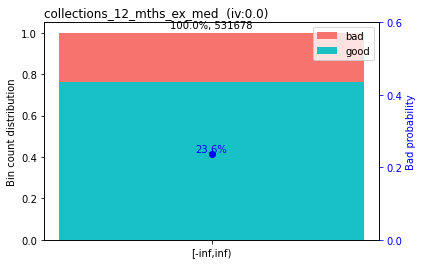

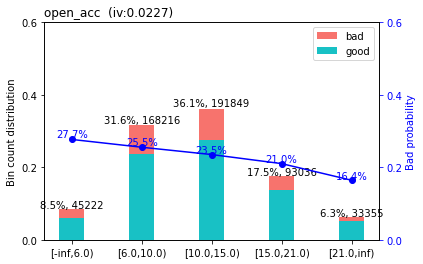

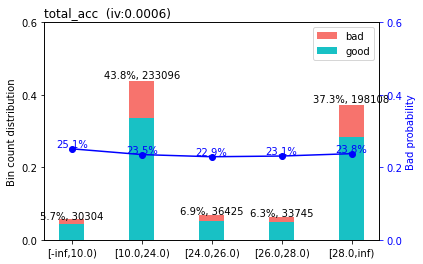

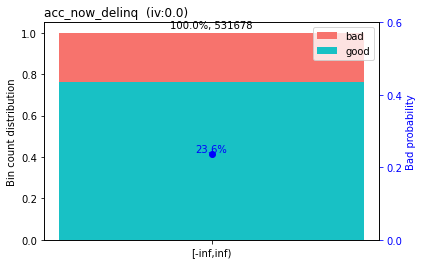

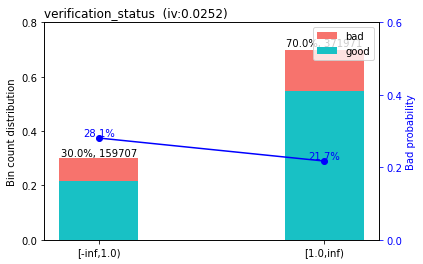

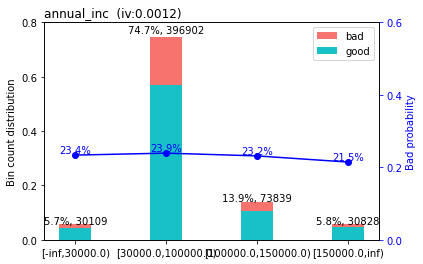

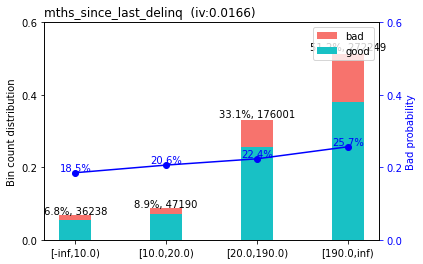

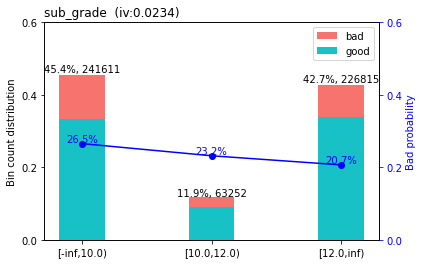

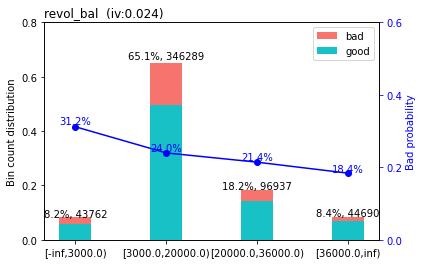

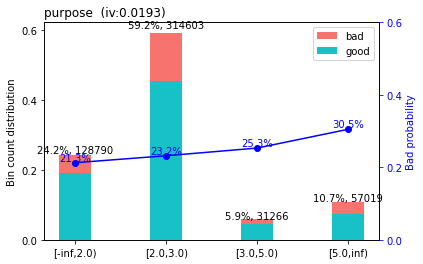

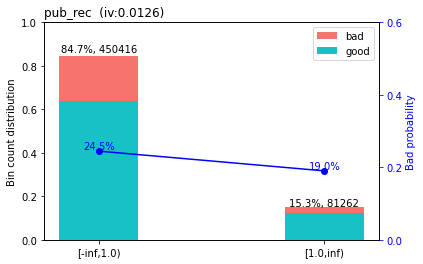

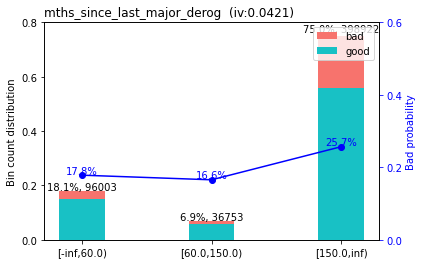

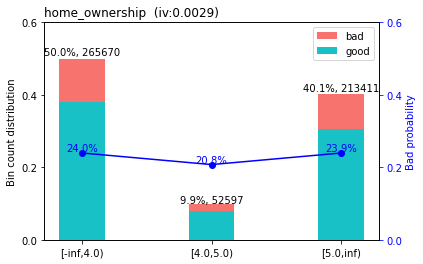

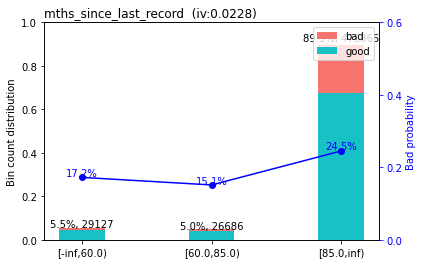

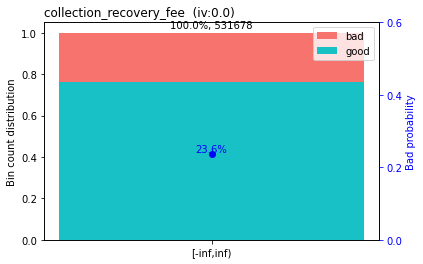

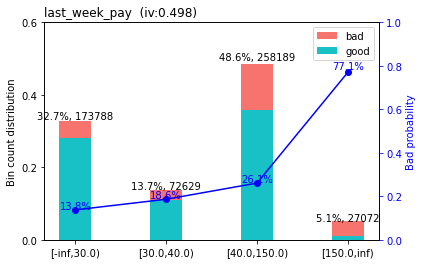

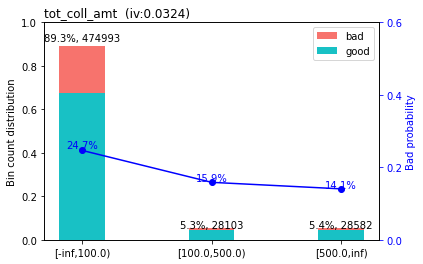

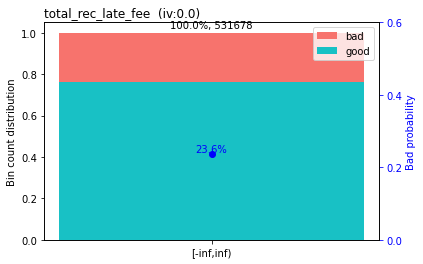

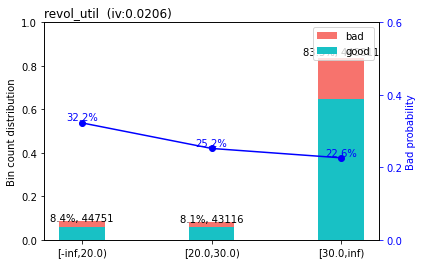

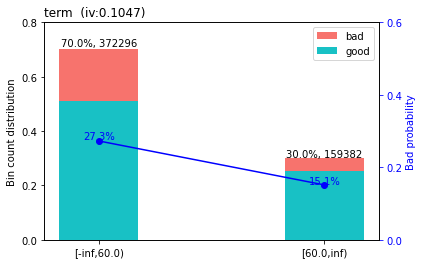

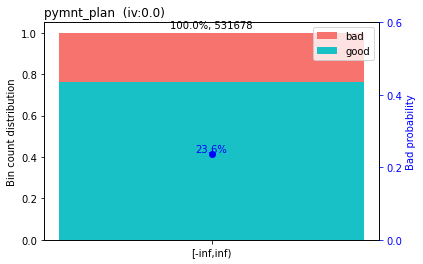

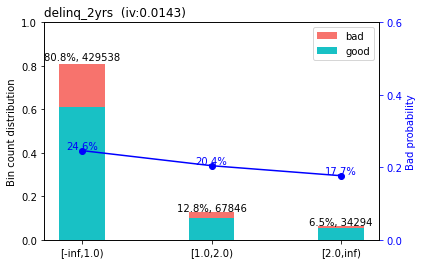

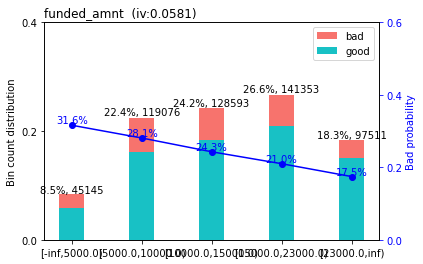

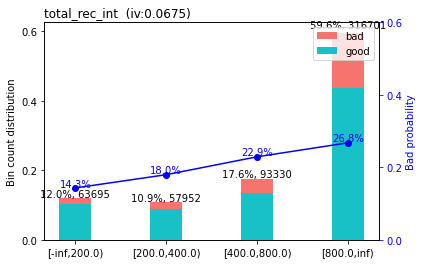

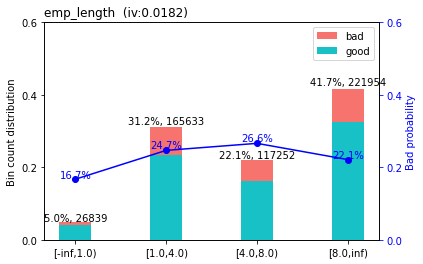

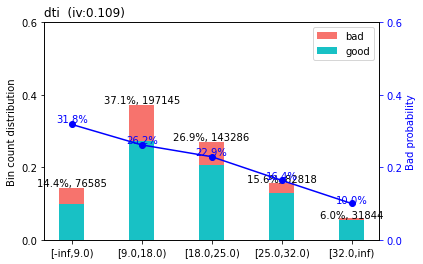

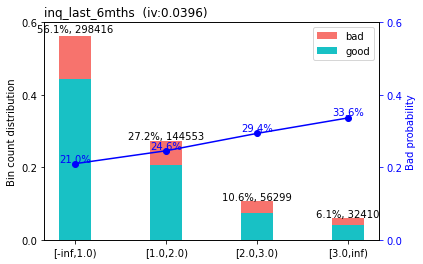

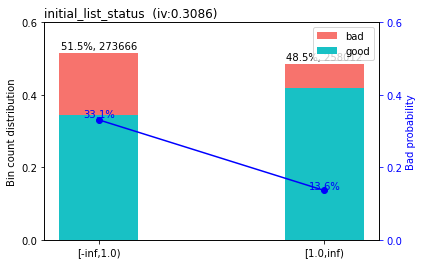

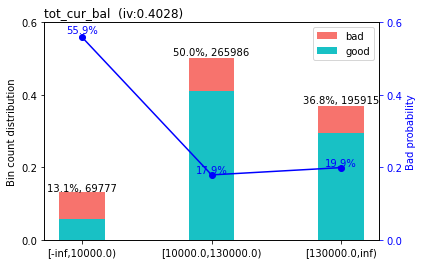

In [61]:
sc.woebin_plot(bins)

##### Check for Correlation

<AxesSubplot:>

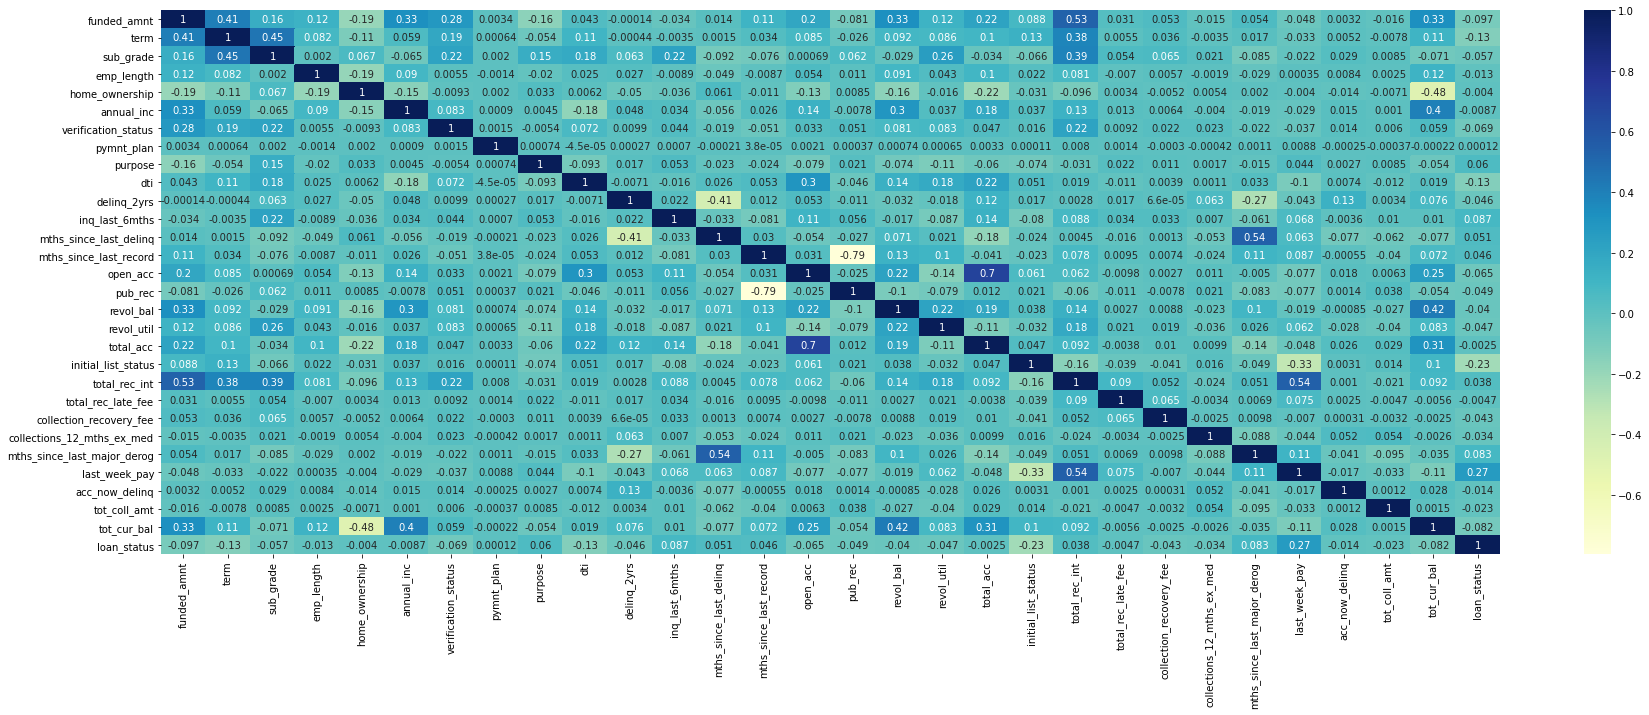

In [62]:
# Generate correlation maxtrix
cor = raw_data.corr()
fig, ax = plt.subplots(figsize=(30,10))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True,cmap="YlGnBu", ax=ax)

### Rebinning of Columns

#### Shape of rebinned DataFrame

In [63]:
# Split data into 70% train and 30% test

train, test = sc.split_df(raw_data, 'loan_status', ratio=0.7).values()
print(train.shape)
print(test.shape)

(372175, 30)
(159503, 30)


##### Rebin WoE model

In [64]:
# raw_data['total_rec_late_fee'].max()

In [65]:
# new bins for WoE model
 
bin_list = {'annual_inc': [0,100000,450000,4000000], 'inq_last_6mths': [0,1,5,10,30], 'pub_rec': [0,1,3,5,7], 'mths_since_last_record':[3,4,5,10,30,80],'revol_util':[0,5,10,30,150], 'emp_length':[0,7,8,10], 'open_acc':[0,5,10,20,40,70], 'mths_since_last_major_derog': [0,  60, 80, 140, 200], 'total_acc':[0,1,3,5],'mths_since_last_delinq':[0,6,15,30,40,50], 'delinq_2yrs':[0,1,2,3,4,5], 'home_ownership':[0,3,5], 'collections_12_mths_ex_med':[-1,0,2,3,5], 'pymnt_plan':[-1,0,1], 'acc_now_delinq': [-1,0,1,2,14], 'total_rec_late_fee': [-1,0,16,30,100], 'collection_recovery_fee': [0,20,50,100,400,1000] }
bins_adj = sc.woebin(raw_data, y='loan_status', breaks_list=bin_list)

train_woe = sc.woebin_ply(train, bins_adj)
test_woe = sc.woebin_ply(test, bins_adj)
train_woe

[INFO] creating woe binning ...
Binning on 531678 rows and 30 columns in 00:00:49
[INFO] converting into woe values ...
Woe transformating on 372175 rows and 29 columns in 00:00:30
[INFO] converting into woe values ...
Woe transformating on 159503 rows and 29 columns in 00:00:15


,loan_status,acc_now_delinq_woe,verification_status_woe,revol_bal_woe,purpose_woe,mths_since_last_major_derog_woe,mths_since_last_record_woe,last_week_pay_woe,total_rec_late_fee_woe,pymnt_plan_woe,...,collection_recovery_fee_woe,tot_coll_amt_woe,revol_util_woe,term_woe,delinq_2yrs_woe,emp_length_woe,dti_woe,inq_last_6mths_woe,initial_list_status_woe,tot_cur_bal_woe
0,0,0.002433,-0.108899,-0.126960,-0.024499,-0.437675,-0.491149,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.050042,-1.021810,0.168568,0.468713,-0.349745
1,0,0.002433,-0.108899,0.018829,0.090716,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,0.157683,0.191797,0.053503,0.052611,0.411892,0.168568,-0.675646,1.409850
2,0,0.002433,0.232339,0.018829,-0.024499,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,0.052611,-0.039284,-0.151175,-0.675646,-0.349745
3,0,0.002433,0.232339,0.018829,-0.024499,0.110338,0.042464,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,0.136511,0.168568,0.468713,-0.349745
4,0,0.002433,-0.108899,-0.126960,-0.135805,0.110338,0.042464,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,-0.039284,-0.151175,-0.675646,-0.349745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532422,1,0.002433,-0.108899,0.018829,-0.024499,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,-0.039284,0.168568,-0.675646,-0.218609
532423,0,0.002433,-0.108899,0.018829,-0.024499,0.110338,-0.491149,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,0.136511,-0.151175,0.468713,-0.349745
532425,1,0.002433,-0.108899,0.018829,-0.024499,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,-0.550430,0.053503,-0.050042,-0.454778,0.168568,0.468713,-0.349745
532426,0,0.002433,-0.108899,-0.126960,-0.135805,0.110338,0.042464,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,-0.550430,0.053503,0.052611,0.136511,0.168568,-0.675646,-0.349745


In [66]:
# print(bins_adj)
for variables , bindetails in bins_adj.items():
    print(variables , " : ")
    display(bindetails)
    print("--"*50)

collections_12_mths_ex_med  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,collections_12_mths_ex_med,"[-inf,2.0)",531185,0.999073,405566,125619,0.236488,0.000735,5.404706e-07,0.000811,2.0,False
1,collections_12_mths_ex_med,"[2.0,3.0)",416,0.000782,377,39,0.093750,-1.095918,6.774886e-04,0.000811,3.0,False
2,collections_12_mths_ex_med,"[3.0,5.0)",68,0.000128,62,6,0.088235,-1.162609,1.220257e-04,0.000811,5.0,False
3,collections_12_mths_ex_med,"[5.0,inf)",9,0.000017,8,1,0.111111,-0.906676,1.064994e-05,0.000811,inf,False


----------------------------------------------------------------------------------------------------
open_acc  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,open_acc,"[-inf,5.0)",21347,0.040150,15142,6205,0.290673,0.280641,0.003391,0.020771,5.0,False
1,open_acc,"[5.0,10.0)",192091,0.361292,142802,49289,0.256592,0.109000,0.004415,0.020771,10.0,False
2,open_acc,"[10.0,20.0)",276212,0.519510,213215,62997,0.228075,-0.046456,0.001107,0.020771,20.0,False
3,open_acc,"[20.0,40.0)",41583,0.078211,34460,7123,0.171296,-0.403712,0.011381,0.020771,40.0,False
4,open_acc,"[40.0,70.0)",438,0.000824,387,51,0.116438,-0.853841,0.000467,0.020771,70.0,False
5,open_acc,"[70.0,inf)",7,0.000013,7,0,0.000000,-0.878512,0.000009,0.020771,inf,False


----------------------------------------------------------------------------------------------------
total_acc  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,total_acc,"[-inf,3.0)",43,0.000081,15,28,0.651163,1.796920,0.000334,0.001057,3.0,False
1,total_acc,"[3.0,5.0)",1929,0.003628,1310,619,0.320892,0.423088,0.000719,0.001057,5.0,False
2,total_acc,"[5.0,inf)",529706,0.996291,404688,125018,0.236014,-0.001893,0.000004,0.001057,inf,False


----------------------------------------------------------------------------------------------------
acc_now_delinq  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,acc_now_delinq,"[-inf,1.0)",529219,0.995375,403902,125317,0.236796,0.002433,0.000006,0.001555,1.0,False
1,acc_now_delinq,"[1.0,2.0)",2300,0.004326,1970,330,0.143478,-0.613938,0.001367,0.001555,2.0,False
2,acc_now_delinq,"[2.0,14.0)",158,0.000297,140,18,0.113924,-0.878512,0.000177,0.001555,14.0,False
3,acc_now_delinq,"[14.0,inf)",1,0.000002,1,0,0.000000,1.067398,0.000005,0.001555,inf,False


----------------------------------------------------------------------------------------------------
verification_status  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,verification_status,"[-inf,1.0)",159707,0.300383,114859,44848,0.280814,0.232339,0.017191,0.025248,1.0,False
1,verification_status,"[1.0,inf)",371971,0.699617,291154,80817,0.217267,-0.108899,0.008058,0.025248,inf,False


----------------------------------------------------------------------------------------------------
annual_inc  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,annual_inc,"[-inf,100000.0)",427011,0.803138,325054,101957,0.238769,0.013325,0.000143,0.000751,100000.0,False
1,annual_inc,"[100000.0,450000.0)",103713,0.195067,80211,23502,0.226606,-0.054810,0.000578,0.000751,450000.0,False
2,annual_inc,"[450000.0,4000000.0)",934,0.001757,731,203,0.217345,-0.108442,0.000020,0.000751,4000000.0,False
3,annual_inc,"[4000000.0,inf)",20,0.000038,17,3,0.150000,-0.561836,0.000010,0.000751,inf,False


----------------------------------------------------------------------------------------------------
mths_since_last_delinq  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mths_since_last_delinq,"[-inf,6.0)",15962,0.030022,13041,2921,0.182997,-0.323407,0.002870,0.01421,6.0,False
1,mths_since_last_delinq,"[6.0,15.0)",44767,0.084199,36030,8737,0.195166,-0.244020,0.004689,0.01421,15.0,False
2,mths_since_last_delinq,"[15.0,30.0)",64055,0.120477,50442,13613,0.212520,-0.137033,0.002180,0.01421,30.0,False
3,mths_since_last_delinq,"[30.0,40.0)",36821,0.069254,28635,8186,0.222319,-0.079439,0.000428,0.01421,40.0,False
4,mths_since_last_delinq,"[40.0,50.0)",32184,0.060533,24727,7457,0.231699,-0.025977,0.000041,0.01421,50.0,False
5,mths_since_last_delinq,"[50.0,inf)",337889,0.635514,253138,84751,0.250825,0.078548,0.004002,0.01421,inf,False


----------------------------------------------------------------------------------------------------
sub_grade  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,sub_grade,"[-inf,10.0)",241611,0.454431,177495,64116,0.265369,0.154517,0.011287,0.023424,10.0,False
1,sub_grade,"[10.0,12.0)",63252,0.118967,48587,14665,0.231850,-0.025127,0.000075,0.023424,12.0,False
2,sub_grade,"[12.0,inf)",226815,0.426602,179931,46884,0.206706,-0.172131,0.012063,0.023424,inf,False


----------------------------------------------------------------------------------------------------
revol_bal  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,revol_bal,"[-inf,3000.0)",43762,0.082309,30111,13651,0.311937,0.381688,0.013156,0.023977,3000.0,False
1,revol_bal,"[3000.0,20000.0)",346289,0.651313,263259,83030,0.239771,0.018829,0.000232,0.023977,20000.0,False
2,revol_bal,"[20000.0,36000.0)",96937,0.182323,76172,20765,0.214211,-0.126960,0.002840,0.023977,36000.0,False
3,revol_bal,"[36000.0,inf)",44690,0.084055,36471,8219,0.183911,-0.317303,0.007750,0.023977,inf,False


----------------------------------------------------------------------------------------------------
purpose  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,purpose,"[-inf,2.0)",128790,0.242233,101393,27397,0.212726,-0.135805,0.004307,0.019307,2.0,False
1,purpose,"[2.0,3.0)",314603,0.591717,241627,72976,0.231962,-0.024499,0.000353,0.019307,3.0,False
2,purpose,"[3.0,5.0)",31266,0.058806,23352,7914,0.253118,0.090716,0.000495,0.019307,5.0,False
3,purpose,"[5.0,inf)",57019,0.107243,39641,17378,0.304776,0.348107,0.014152,0.019307,inf,False


----------------------------------------------------------------------------------------------------
pub_rec  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,pub_rec,"[-inf,1.0)",450416,0.847159,340206,110210,0.244685,0.045602,0.001783,0.015437,1.0,False
1,pub_rec,"[1.0,3.0)",76674,0.144211,61738,14936,0.194799,-0.246360,0.008180,0.015437,3.0,False
2,pub_rec,"[3.0,5.0)",3663,0.006890,3219,444,0.121212,-0.808236,0.003552,0.015437,5.0,False
3,pub_rec,"[5.0,7.0)",662,0.001245,603,59,0.089124,-1.151614,0.001170,0.015437,7.0,False
4,pub_rec,"[7.0,inf)",263,0.000495,247,16,0.060837,-1.564034,0.000752,0.015437,inf,False


----------------------------------------------------------------------------------------------------
mths_since_last_major_derog  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mths_since_last_major_derog,"[-inf,60.0)",96003,0.180566,78883,17120,0.178328,-0.354953,0.020606,0.04208,60.0,False
1,mths_since_last_major_derog,"[60.0,80.0)",32319,0.060787,26937,5382,0.166527,-0.437675,0.010293,0.04208,80.0,False
2,mths_since_last_major_derog,"[80.0,140.0)",4353,0.008187,3661,692,0.158971,-0.493140,0.001731,0.04208,140.0,False
3,mths_since_last_major_derog,"[140.0,200.0)",106,0.000199,90,16,0.150943,-0.554455,0.000052,0.04208,200.0,False
4,mths_since_last_major_derog,"[200.0,inf)",398897,0.750260,296442,102455,0.256846,0.110338,0.009398,0.04208,inf,False


----------------------------------------------------------------------------------------------------
home_ownership  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,home_ownership,"[-inf,3.0)",265553,0.499462,202001,63552,0.239319,0.016351,0.000134,0.002669,3.0,False
1,home_ownership,"[3.0,5.0)",52714,0.099146,41708,11006,0.208787,-0.159487,0.002415,0.002669,5.0,False
2,home_ownership,"[5.0,inf)",213411,0.401391,162304,51107,0.239477,0.017216,0.000120,0.002669,inf,False


----------------------------------------------------------------------------------------------------
mths_since_last_record  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,mths_since_last_record,"[-inf,3.0)",774,0.001456,248,526,0.679587,1.924638,0.006880,0.03091,3.0,False
1,mths_since_last_record,"[3.0,4.0)",70,0.000132,65,5,0.071429,-1.392184,0.000167,0.03091,4.0,False
2,mths_since_last_record,"[4.0,5.0)",94,0.000177,86,8,0.085106,-1.202140,0.000178,0.03091,5.0,False
3,mths_since_last_record,"[5.0,10.0)",652,0.001226,572,80,0.122699,-0.794347,0.000613,0.03091,10.0,False
4,mths_since_last_record,"[10.0,30.0)",5151,0.009688,4462,689,0.133760,-0.695346,0.003829,0.03091,30.0,False
5,mths_since_last_record,"[30.0,80.0)",44575,0.083838,37477,7098,0.159237,-0.491149,0.017594,0.03091,80.0,False
6,mths_since_last_record,"[80.0,inf)",480362,0.903483,363103,117259,0.244105,0.042464,0.001647,0.03091,inf,False


----------------------------------------------------------------------------------------------------
collection_recovery_fee  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,collection_recovery_fee,"[-inf,20.0)",524105,0.985756,398440,125665,0.239771,0.018792,0.000350,0.120633,20.0,False
1,collection_recovery_fee,"[20.0,50.0)",1991,0.003745,1991,0,0.000000,-6.529023,0.031970,0.120633,50.0,False
2,collection_recovery_fee,"[50.0,100.0)",533,0.001002,533,0,0.000000,-5.211152,0.006804,0.120633,100.0,False
3,collection_recovery_fee,"[100.0,400.0)",2691,0.005061,2691,0,0.000000,-6.830299,0.045221,0.120633,400.0,False
4,collection_recovery_fee,"[400.0,1000.0)",1986,0.003735,1986,0,0.000000,-6.526509,0.031877,0.120633,1000.0,False
5,collection_recovery_fee,"[1000.0,inf)",372,0.000700,372,0,0.000000,-4.851525,0.004410,0.120633,inf,False


----------------------------------------------------------------------------------------------------
last_week_pay  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,last_week_pay,"[-inf,30.0)",173788,0.326867,149880,23908,0.137570,-0.662856,0.118584,0.498008,30.0,False
1,last_week_pay,"[30.0,40.0)",72629,0.136603,59084,13545,0.186496,-0.300177,0.011327,0.498008,40.0,False
2,last_week_pay,"[40.0,150.0)",258189,0.485612,190840,67349,0.260852,0.131218,0.008648,0.498008,150.0,False
3,last_week_pay,"[150.0,inf)",27072,0.050918,6209,20863,0.770649,2.384743,0.359448,0.498008,inf,False


----------------------------------------------------------------------------------------------------
tot_coll_amt  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tot_coll_amt,"[-inf,100.0)",474993,0.893385,357802,117191,0.246722,0.056591,0.002904,0.032401,100.0,False
1,tot_coll_amt,"[100.0,500.0)",28103,0.052857,23647,4456,0.158560,-0.496219,0.011305,0.032401,500.0,False
2,tot_coll_amt,"[500.0,inf)",28582,0.053758,24564,4018,0.140578,-0.637732,0.018192,0.032401,inf,False


----------------------------------------------------------------------------------------------------
total_rec_late_fee  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,total_rec_late_fee,"[-inf,16.0)",526944,0.991096,402259,124685,0.236619,0.001460,0.000002,0.000362,16.0,False
1,total_rec_late_fee,"[16.0,30.0)",2336,0.004394,1808,528,0.226027,-0.058115,0.000015,0.000362,30.0,False
2,total_rec_late_fee,"[30.0,100.0)",2300,0.004326,1865,435,0.189130,-0.282905,0.000320,0.000362,100.0,False
3,total_rec_late_fee,"[100.0,inf)",98,0.000184,81,17,0.173469,-0.388470,0.000025,0.000362,inf,False


----------------------------------------------------------------------------------------------------
revol_util  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,revol_util,"[-inf,5.0)",9103,0.017121,5476,3627,0.398440,0.760796,1.169740e-02,0.023421,5.0,False
1,revol_util,"[5.0,10.0)",8798,0.016548,5734,3064,0.348261,0.546073,5.602487e-03,0.023421,10.0,False
2,revol_util,"[10.0,30.0)",69966,0.131595,51356,18610,0.265986,0.157683,3.406515e-03,0.023421,30.0,False
3,revol_util,"[30.0,150.0)",443802,0.834720,343440,100362,0.226141,-0.057463,2.714393e-03,0.023421,150.0,False
4,revol_util,"[150.0,inf)",9,0.000017,7,2,0.222222,-0.079997,1.060363e-07,0.023421,inf,False


----------------------------------------------------------------------------------------------------
term  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,term,"[-inf,60.0)",372296,0.700228,270771,101525,0.27270,0.191797,0.027043,0.104654,60.0,False
1,term,"[60.0,inf)",159382,0.299772,135242,24140,0.15146,-0.550430,0.077610,0.104654,inf,False


----------------------------------------------------------------------------------------------------
pymnt_plan  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,pymnt_plan,"[-inf,1.0)",531670,0.999985,406007,125663,0.236355,-0.000001,1.293877e-12,8.434903e-08,1.0,False
1,pymnt_plan,"[1.0,inf)",8,0.000015,6,2,0.250000,0.074153,8.434773e-08,8.434903e-08,inf,False


----------------------------------------------------------------------------------------------------
delinq_2yrs  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,delinq_2yrs,"[-inf,1.0)",429538,0.807891,323808,105730,0.246148,0.053503,0.002345,0.015174,1.0,False
1,delinq_2yrs,"[1.0,2.0)",67846,0.127607,53974,13872,0.204463,-0.185864,0.004191,0.015174,2.0,False
2,delinq_2yrs,"[2.0,3.0)",20134,0.037869,16310,3824,0.189927,-0.277716,0.002705,0.015174,3.0,False
3,delinq_2yrs,"[3.0,4.0)",7255,0.013645,6031,1224,0.168711,-0.422023,0.002158,0.015174,4.0,False
4,delinq_2yrs,"[4.0,5.0)",3147,0.005919,2672,475,0.150937,-0.554502,0.001553,0.015174,5.0,False
5,delinq_2yrs,"[5.0,inf)",3758,0.007068,3218,540,0.143693,-0.612181,0.002221,0.015174,inf,False


----------------------------------------------------------------------------------------------------
funded_amnt  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,funded_amnt,"[-inf,5000.0)",45145,0.084910,30871,14274,0.316181,0.401388,0.015073,0.058146,5000.0,False
1,funded_amnt,"[5000.0,10000.0)",119076,0.223963,85619,33457,0.280972,0.233119,0.012906,0.058146,10000.0,False
2,funded_amnt,"[10000.0,15000.0)",128593,0.241863,97361,31232,0.242875,0.035783,0.000313,0.058146,15000.0,False
3,funded_amnt,"[15000.0,23000.0)",141353,0.265862,111669,29684,0.209999,-0.152165,0.005907,0.058146,23000.0,False
4,funded_amnt,"[23000.0,inf)",97511,0.183402,80493,17018,0.174524,-0.381133,0.023946,0.058146,inf,False


----------------------------------------------------------------------------------------------------
total_rec_int  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,total_rec_int,"[-inf,200.0)",63695,0.119800,54578,9117,0.143135,-0.616725,0.038159,0.067468,200.0,False
1,total_rec_int,"[200.0,400.0)",57952,0.108998,47542,10410,0.179631,-0.346081,0.011855,0.067468,400.0,False
2,total_rec_int,"[400.0,800.0)",93330,0.175539,71956,21374,0.229015,-0.041114,0.000294,0.067468,800.0,False
3,total_rec_int,"[800.0,inf)",316701,0.595663,231937,84764,0.267647,0.166171,0.017160,0.067468,inf,False


----------------------------------------------------------------------------------------------------
emp_length  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,emp_length,"[-inf,7.0)",283077,0.532422,213445,69632,0.245983,0.052611,0.001494,0.005459,7.0,False
1,emp_length,"[7.0,8.0)",26647,0.050119,19720,6927,0.259954,0.126559,0.000829,0.005459,8.0,False
2,emp_length,"[8.0,10.0)",47058,0.088508,36355,10703,0.227443,-0.050042,0.000219,0.005459,10.0,False
3,emp_length,"[10.0,inf)",174896,0.328951,136493,38403,0.219576,-0.095372,0.002917,0.005459,inf,False


----------------------------------------------------------------------------------------------------
dti  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,dti,"[-inf,9.0)",76585,0.144044,52196,24389,0.318457,0.411892,0.026988,0.109042,9.0,False
1,dti,"[9.0,18.0)",197145,0.370798,145518,51627,0.261873,0.136511,0.007156,0.109042,18.0,False
2,dti,"[18.0,25.0)",143286,0.269498,110425,32861,0.229339,-0.039284,0.000412,0.109042,25.0,False
3,dti,"[25.0,32.0)",82818,0.155767,69222,13596,0.164167,-0.454778,0.028332,0.109042,32.0,False
4,dti,"[32.0,inf)",31844,0.059893,28652,3192,0.100239,-1.021810,0.046153,0.109042,inf,False


----------------------------------------------------------------------------------------------------
inq_last_6mths  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,inq_last_6mths,"[-inf,1.0)",298416,0.561272,235700,62716,0.210163,-0.151175,0.012313,0.029297,1.0,False
1,inq_last_6mths,"[1.0,5.0)",229900,0.432405,168260,61640,0.268117,0.168568,0.012827,0.029297,5.0,False
2,inq_last_6mths,"[5.0,10.0)",3313,0.006231,2041,1272,0.383942,0.699918,0.003566,0.029297,10.0,False
3,inq_last_6mths,"[10.0,30.0)",48,0.000090,12,36,0.750000,2.271380,0.000584,0.029297,30.0,False
4,inq_last_6mths,"[30.0,inf)",1,0.000002,0,1,1.000000,1.278128,0.000007,0.029297,inf,False


----------------------------------------------------------------------------------------------------
initial_list_status  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,initial_list_status,"[-inf,1.0)",273666,0.514721,183106,90560,0.330914,0.468713,0.126393,0.308588,1.0,False
1,initial_list_status,"[1.0,inf)",258012,0.485279,222907,35105,0.136060,-0.675646,0.182195,0.308588,inf,False


----------------------------------------------------------------------------------------------------
tot_cur_bal  : 


,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,tot_cur_bal,"[-inf,10000.0)",69777,0.131239,30772,39005,0.558995,1.409850,0.330748,0.402847,10000.0,False
1,tot_cur_bal,"[10000.0,130000.0)",265986,0.500276,218350,47636,0.179092,-0.349745,0.055511,0.402847,130000.0,False
2,tot_cur_bal,"[130000.0,inf)",195915,0.368484,156891,39024,0.199188,-0.218609,0.016588,0.402847,inf,False


----------------------------------------------------------------------------------------------------


In [67]:
train_woe

,loan_status,acc_now_delinq_woe,verification_status_woe,revol_bal_woe,purpose_woe,mths_since_last_major_derog_woe,mths_since_last_record_woe,last_week_pay_woe,total_rec_late_fee_woe,pymnt_plan_woe,...,collection_recovery_fee_woe,tot_coll_amt_woe,revol_util_woe,term_woe,delinq_2yrs_woe,emp_length_woe,dti_woe,inq_last_6mths_woe,initial_list_status_woe,tot_cur_bal_woe
0,0,0.002433,-0.108899,-0.126960,-0.024499,-0.437675,-0.491149,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.050042,-1.021810,0.168568,0.468713,-0.349745
1,0,0.002433,-0.108899,0.018829,0.090716,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,0.157683,0.191797,0.053503,0.052611,0.411892,0.168568,-0.675646,1.409850
2,0,0.002433,0.232339,0.018829,-0.024499,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,0.052611,-0.039284,-0.151175,-0.675646,-0.349745
3,0,0.002433,0.232339,0.018829,-0.024499,0.110338,0.042464,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,0.136511,0.168568,0.468713,-0.349745
4,0,0.002433,-0.108899,-0.126960,-0.135805,0.110338,0.042464,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,-0.039284,-0.151175,-0.675646,-0.349745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532422,1,0.002433,-0.108899,0.018829,-0.024499,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,-0.039284,0.168568,-0.675646,-0.218609
532423,0,0.002433,-0.108899,0.018829,-0.024499,0.110338,-0.491149,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,0.191797,0.053503,-0.095372,0.136511,-0.151175,0.468713,-0.349745
532425,1,0.002433,-0.108899,0.018829,-0.024499,0.110338,0.042464,-0.662856,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,-0.550430,0.053503,-0.050042,-0.454778,0.168568,0.468713,-0.349745
532426,0,0.002433,-0.108899,-0.126960,-0.135805,0.110338,0.042464,0.131218,0.00146,-0.000001,...,0.018792,0.056591,-0.057463,-0.550430,0.053503,0.052611,0.136511,0.168568,-0.675646,-0.349745


### Logistic Regression

In [68]:
#create the X, y parts of data for train and test
y_train = train_woe.loc[:,'loan_status']
X_train = train_woe.loc[:,train_woe.columns != 'loan_status']
y_test = test_woe.loc[:,'loan_status']
X_test = test_woe.loc[:,train_woe.columns != 'loan_status']

#create a logistic regression model object
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
print(lr.coef_)
print(lr.intercept_)

[[ 0.24498527  0.24925899  0.12655057  0.20234502  0.35234132  0.4262798
   0.59087594  3.07838009 -0.00677123  0.28708765  0.52589232  0.45291258
  -0.17939693 -1.33244809 -0.78275409  0.12730462  0.15918266  0.34446277
   0.80656091  1.51870887  0.59509536  0.54419668  0.74303648  0.4884978
  -0.06677684  0.54321593  0.88898072  0.58406314  0.54547689]]
[-1.16186803]


In [69]:
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

array([[<AxesSubplot:title={'center':'score'}>]], dtype=object)

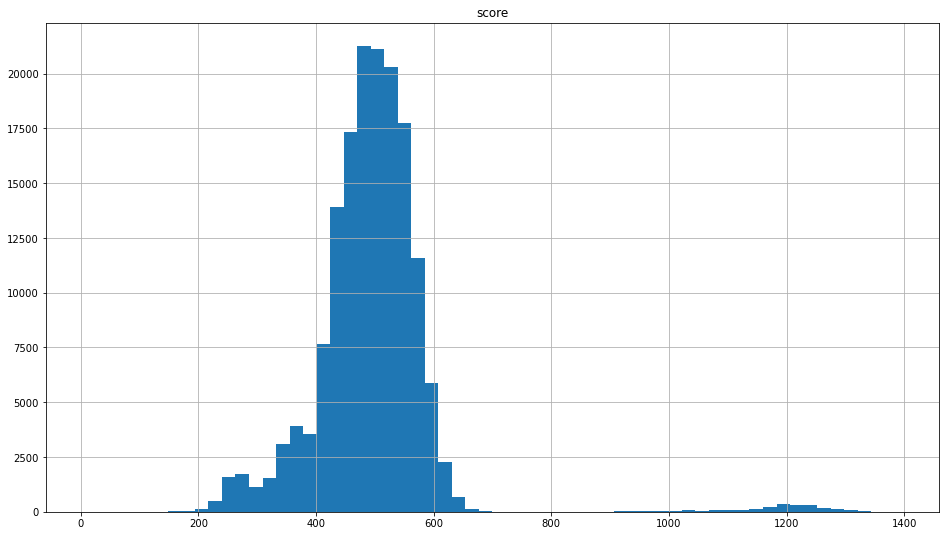

In [70]:
# score ------
card = sc.scorecard(bins_adj, lr, X_train.columns)

# credit score
train_score = sc.scorecard_ply(train, card, print_step=0)
test_score = sc.scorecard_ply(test, card, print_step=0)
test_score.hist(figsize=(16,9),bins=60)

In [85]:
pprint.pprint(card)

{'acc_now_delinq':           variable         bin  points
13  acc_now_delinq  [-inf,1.0)    -0.0
14  acc_now_delinq   [1.0,2.0)    11.0
15  acc_now_delinq  [2.0,14.0)    16.0
16  acc_now_delinq  [14.0,inf)   -19.0,
 'annual_inc':       variable                   bin  points
19  annual_inc       [-inf,100000.0)     1.0
20  annual_inc   [100000.0,450000.0)    -3.0
21  annual_inc  [450000.0,4000000.0)    -6.0
22  annual_inc       [4000000.0,inf)   -32.0,
 'basepoints':      variable  bin  points
0  basepoints  NaN   471.0,
 'collection_recovery_fee':                    variable             bin  points
60  collection_recovery_fee     [-inf,20.0)    -2.0
61  collection_recovery_fee     [20.0,50.0)   715.0
62  collection_recovery_fee    [50.0,100.0)   571.0
63  collection_recovery_fee   [100.0,400.0)   748.0
64  collection_recovery_fee  [400.0,1000.0)   715.0
65  collection_recovery_fee    [1000.0,inf)   531.0,
 'collections_12_mths_ex_med':                      variable         bin  points


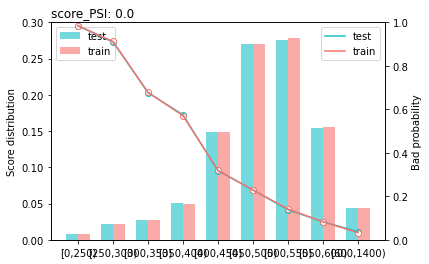

{'psi':   variable       PSI
 0    score  0.000044,
 'pic': {'score': <Figure size 432x288 with 2 Axes>}}

In [71]:
# psi
sc.perf_psi(
  score = {'train':train_score, 'test':test_score},
  label = {'train':y_train, 'test':y_test}
)

### Columns used

In [72]:
raw_data.columns

Index(['funded_amnt', 'term', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'pymnt_plan', 'purpose', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'total_rec_int',
       'total_rec_late_fee', 'collection_recovery_fee',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'last_week_pay', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'loan_status'],
      dtype='object')

### Accuracy

In [73]:
y_pred = lr.predict(X_train)
# confusion_matrix = confusion_matrix(y_test, y_pred)
# print(confusion_matrix)

In [74]:
print("Training accuracy",lr.score(X_train,y_train).round(2))  
print()
print("Testing accuracy",lr.score(X_test, y_test).round(2))
print()

Training accuracy 0.81

Testing accuracy 0.81



#### Test Defaulter Data 

In [75]:
test_pred = lr.predict([train_woe.loc[532410][1:]])
test_prob = lr.predict_proba([train_woe.loc[532410][1:]])

print('Predicted value = ', test_pred)
print('Probabilities: 0 = ', test_prob[0][0], ', 1 = ', test_prob[0][1])

Predicted value =  [1]
Probabilities: 0 =  0.05321885116993241 , 1 =  0.9467811488300676


In [76]:
test_pred = lr.predict([train_woe.loc[532412][1:]])
test_prob = lr.predict_proba([train_woe.loc[532412][1:]])

print('Predicted value = ', test_pred)
print('Probabilities: 0 = ', test_prob[0][0], ', 1 = ', test_prob[0][1])

Predicted value =  [0]
Probabilities: 0 =  0.7334141563566026 , 1 =  0.26658584364339744


### Evaluate Logistic Regression Performance

/Users/venustan/opt/anaconda3/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/Users/venustan/opt/anaconda3/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


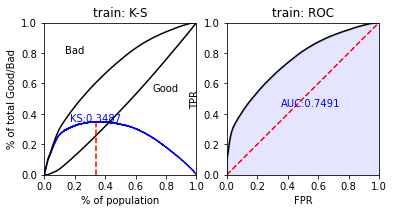

/Users/venustan/opt/anaconda3/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)
/Users/venustan/opt/anaconda3/lib/python3.8/site-packages/scorecardpy/perf.py:318: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(subplot_nrows,subplot_ncols,i+1)


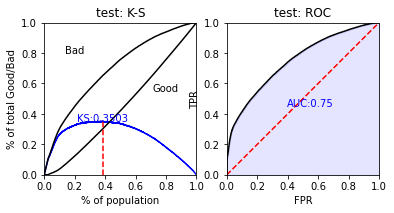

In [77]:
# EVALUATE LOG-REGRESSION PERFORMANCE
# Evaluate the performance of the Logistic Regression
train_pred = lr.predict_proba(X_train)[:,1]
test_pred = lr.predict_proba(X_test)[:,1]

# performance ks & roc
train_perf = sc.perf_eva(y_train, train_pred, title = "train")
test_perf = sc.perf_eva(y_test, test_pred, title = "test")

In [78]:
# Generate model predictions on test data. Print Evaluation metrics of the model
y_pred = lr.predict(X_test)
print(classification_report(y_pred, y_test))
# print(confusion_matrix(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.82      0.88    144219
           1       0.29      0.72      0.42     15284

    accuracy                           0.81    159503
   macro avg       0.63      0.77      0.65    159503
weighted avg       0.90      0.81      0.84    159503



# Conclusion

### Method Comparison:
Method 1 Accuracy: 0.78

Method 2 Accuracy: 0.81


## Application will use Method 2 model

In [79]:
#######
# END #
#######